# **PCLab#4 - Group 2 - Morresi Masia Valdo**

The objective of the 4th lab is to experiment with a hybrid approach inspired by two distinct papers discussed in class. One paper emphasizes the utilization of low-frequency yet high-dimensional data, including balance sheets and financial indicators, while the other focuses on low-dimensional but high-frequency data, represented in the form of low-quality images processed by a Convolutional Neural Network (CNN). The goal is to determine whether this mixed approach could potentially enhance the results or, conversely, prove less effective than existing state-of-the-art models.

In [188]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Dropout, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Task #1
## *Basic manipulation and descriptive statistics*

In [105]:
prices = pd.read_csv('./data/Data_PCLab4_Stock_Price.csv')
volumes = pd.read_csv('./data/Data_PCLab4_Stock_Volume.csv')
stocks = prices.columns[1:-1]

In [106]:
prices.head()

Date       AAPL         BA          T    MGM        AMZN         IBM  \
0  2012-01-12  60.198570  75.510002  30.120001  12.13  175.929993  180.550003   
1  2012-01-13  59.972858  74.599998  30.070000  12.35  178.419998  179.160004   
2  2012-01-17  60.671429  75.239998  30.250000  12.25  181.660004  180.000000   
3  2012-01-18  61.301430  75.059998  30.330000  12.73  189.440002  181.070007   
4  2012-01-19  61.107143  75.559998  30.420000  12.80  194.449997  180.520004   

        TSLA        GOOG        sp500  
0  28.250000  313.644379  1295.500000  
1  22.790001  311.328064  1289.089966  
2  26.600000  313.116364  1293.670044  
3  26.809999  315.273285  1308.040039  
4  26.760000  318.590851  1314.500000

- What is the average trading volume for Apple stock ?

In [107]:
print(f"The average trading volume of Apple is {volumes['AAPL'].mean():.2f} shares")

The average trading volume of Apple is 58203317.42 shares


- What is the maximum trading volume for S&P500 ?

In [108]:
print(f"The maximum trading volume for S&P500 is {volumes['sp500'].max():.2f} shares")

The maximum trading volume for S&P500 is 9044690000.00 shares


- Which security is traded the most ? Comment on your answer

In [109]:
print(f"The security traded the most is {volumes.drop('sp500', axis=1).mean().idxmax()}")

The security traded the most is AAPL


We excluded the S&P500 from the analysis because it is an index, so the most traded security is Apple.

Apple is the most traded stocks among these due to several reasons. Firstly, it's a tech giant with a massive global consumer base, which attracts significant investor interest. Its products that have a widespread appeal, ensuring a constant demand. Moreover, Apple consistently innovates and releases new products, driving speculation and trading activity. Its financial health, including strong revenue and profitability, makes it an attractive choice for both institutional and retail investors. Apple's presence in major indices like the S&P 500 and its influence on the broader market further amplifies its trading.


- Plot the time series of volumes for all stocks (raw and normalized)

In [110]:
# Interactive plots with plotly of raw volumes

fig = go.Figure()

for col in volumes.columns[1:-1]: # Drop date and S&P500
    fig.add_trace(go.Scatter(x=volumes['Date'], y=volumes[col], name=col))

fig.update_layout(title='Raw volumes of all stocks',
                     xaxis_title='Time',
                     yaxis_title='Volume')

fig.show()

In [111]:
# Plot the normalized volumes

fig = go.Figure()

for col in volumes.columns[1:-1]: # Drop date and S&P500
    fig.add_trace(go.Scatter(x=volumes['Date'], y=volumes[col]/volumes[col].iloc[0], name=col))

fig.update_layout(title='Normalized volumes of all stocks',
                        xaxis_title='Time',
                        yaxis_title='Volume')

fig.show()

In [112]:
norm_avg_volumes = volumes.drop(['sp500', 'Date'], axis=1).mean() / volumes.drop(['sp500', 'Date'], axis=1).iloc[0]
norm_avg_prices = prices.drop(['sp500', 'Date'], axis=1).mean() / prices.drop(['sp500', 'Date'], axis=1).iloc[0]

categories = ['processing cost','mechanical properties','chemical stability',
              'thermal stability', 'device integration']

fig = go.Figure()

fig.add_trace(go.Scatterpolar(
      r=norm_avg_prices,
      theta=stocks,
      fill='toself',
      name='Average normalized prices',
))

fig.add_trace(go.Scatterpolar(
      r=norm_avg_volumes,
      theta=stocks,
      fill='toself',
      name='Average normalized volumes'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[min(norm_avg_prices.min(), norm_avg_volumes.min())-0.1, max(norm_avg_prices.max(), norm_avg_volumes.max())+0.1]
    )),
  showlegend=False
)

fig.update_layout(title='Average normalized prices and volumes of all stocks')

fig.show()

- Is there a correlation between change in prices (returns) and change in volumes ?

In [113]:
# create new dfs with daily change in price and volume
def compute_returns(df):
    returns_df = np.log(df.drop(['Date'], axis=1)/df.drop(['Date'], axis=1).shift(1))
    returns_df['Date'] = df['Date'] # Attach the date column to the new dataframe
    returns_df.insert(0, 'Date', returns_df.pop('Date')) # Move the date column to the first column
    return returns_df

pchange = compute_returns(prices)
vchange = compute_returns(volumes)

vchange.head()

Date      AAPL        BA         T       MGM      AMZN       IBM  \
0  2012-01-12       NaN       NaN       NaN       NaN       NaN       NaN   
1  2012-01-13  0.061278  0.165168 -0.182131 -0.073588 -0.124885 -0.264989   
2  2012-01-17  0.072008 -0.226592  0.061576 -0.071115  0.171800  0.128551   
3  2012-01-18  0.130625  0.124222 -0.065285  0.172076  0.280682 -0.266139   
4  2012-01-19 -0.055918  0.253317  0.147895 -0.270985 -0.051832  0.621754   

       TSLA      GOOG     sp500  
0       NaN       NaN       NaN  
1  2.020491  0.207357 -0.084986  
2 -0.167610 -0.189350  0.082645  
3 -1.305941  0.369121  0.021137  
4 -0.011091  0.825557  0.086419

In [114]:
corr_list = [pchange[stock].corr(vchange[stock]) for stock in stocks]

# Plot
fig = go.Figure()

for i in range(len(stocks)):
    fig.add_trace(go.Bar(x=[stocks[i]],
                         y=[corr_list[i]],
                         marker_color='lightgreen' if corr_list[i] > 0 else 'lightcoral',
                         name=stocks[i]))
fig.update_layout(title='Correlation between prices and volumes',
                        xaxis_title='Stocks',
                        yaxis_title='Correlation')
fig.show()

In [115]:
# Plot each stock volume and price on the same plot using different y axis

fig = make_subplots(specs=[[{"secondary_y": True}]])
b = []

for stock in stocks:
    fig.add_trace(go.Scatter(x=volumes['Date'], y=volumes[stock], name=f'{stock} vol'))
    fig.add_trace(go.Scatter(x=prices['Date'], y=prices[stock], name=f'{stock} price', yaxis='y2'))

    tf = [s == stock for s in ['AAPL', 'AAPL', 'BA', 'BA', 'T', 'T', 'MGM', 'MGM', 'AMZN', 'AMZN', 'IBM', 'IBM', 'TSLA', 'TSLA', 'GOOG', 'GOOG']]

    b.append(dict(
                args=[{'visible': tf}, {'title': stock}],
                label=stock,
                method='update'
                ))

# Create a custom JavaScript function for on-click events
fig.update_layout(
    updatemenus=[
        dict(
            buttons=b,
            direction='down',
            showactive=True,
            x=0.13,
            xanchor='left',
            y=1.15,
            yanchor='top'
        )
    ])

fig.update_traces(textposition='top center', hoverinfo='x+text')    # Update hover text

fig.update_yaxes(title_text="Volume", secondary_y=False)    # Set y-axes titles
fig.update_yaxes(title_text="Price", secondary_y=True)

fig.update_layout(title='Stock prices and volumes over time')

# Task #2
## *Train and Test samples + Ridge regression*

- Concatenate the date, stock price, and volume in one dataframe

In [116]:
reg_data = pd.merge(prices, volumes, on='Date', suffixes=('_price', '_volume'), sort=True)
reg_data.head()

Date  AAPL_price   BA_price    T_price  MGM_price  AMZN_price  \
0  2012-01-12   60.198570  75.510002  30.120001      12.13  175.929993   
1  2012-01-13   59.972858  74.599998  30.070000      12.35  178.419998   
2  2012-01-17   60.671429  75.239998  30.250000      12.25  181.660004   
3  2012-01-18   61.301430  75.059998  30.330000      12.73  189.440002   
4  2012-01-19   61.107143  75.559998  30.420000      12.80  194.449997   

    IBM_price  TSLA_price  GOOG_price  sp500_price  AAPL_volume  BA_volume  \
0  180.550003   28.250000  313.644379  1295.500000     53146800    3934500   
1  179.160004   22.790001  311.328064  1289.089966     56505400    4641100   
2  180.000000   26.600000  313.116364  1293.670044     60724300    3700100   
3  181.070007   26.809999  315.273285  1308.040039     69197800    4189500   
4  180.520004   26.760000  318.590851  1314.500000     65434600    5397300   

   T_volume  MGM_volume  AMZN_volume  IBM_volume  TSLA_volume  GOOG_volume  \
0  26511100    17891100      5385800     6881000       729300      3764400   
1  22096800    16621800      4753500     5279200      5500400      4631800   
2  23500200    15480800      5644500     6003400      4651600      3832800   
3  22015000    18387600      7473500     4600600      1260200      5544000   
4  25524000    14022900      7096000     8567200      1246300     12657800   

   sp500_volume  
0    4019890000  
1    3692370000  
2    4010490000  
3    4096160000  
4    4465890000

- You want to predict stock prices (or returns) at $t+1$ using stock prices (returns)
and volumes at $t$, $P_{i,t+1} = f (P_{i,t}, V_{i,t})$

### Example for AAPL - Apple

In [117]:
aapl = reg_data[['AAPL_price', 'AAPL_volume']]
aapl_x = aapl[:-1]
aapl_y = aapl['AAPL_price'][1:]

In [120]:
# Scale the data

sc = MinMaxScaler(feature_range = (0, 1))
aapl_x = sc.fit_transform(aapl_x)
aapl_y = sc.fit_transform(aapl_y.values.reshape(-1, 1))

In [121]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(aapl_x, aapl_y, test_size=0.25, shuffle=False)

- Create and train an OLS model

In [122]:
# Create and train an ols model

regressor = LinearRegression()
regressor.fit(X_train, y_train)

print(f'The coefficient of determination R^2 of the prediction is {regressor.score(X_test, y_test):.2f}')
print(f'The intercept is {regressor.intercept_[0]:.5f}')
print(f'The slope of the price is {regressor.coef_[0][0]:.5f}')
print(f'The slope of the volume is {regressor.coef_[0][1]:.5f}')

The coefficient of determination R^2 of the prediction is 0.99
The intercept is 0.00015
The slope of the price is 1.00004
The slope of the volume is 0.00027


In [123]:
y_pred_tr = regressor.predict(X_train)  # Predict the train set results
y_pred_te = regressor.predict(X_test)   # Predict the test set results
y_pred = np.concatenate((y_pred_tr, y_pred_te))

X_sc = pd.DataFrame(np.concatenate((X_train, X_test)))
X_sc.columns = ['AAPL_price', 'AAPL_volume']
X_sc['Date'] = reg_data['Date']

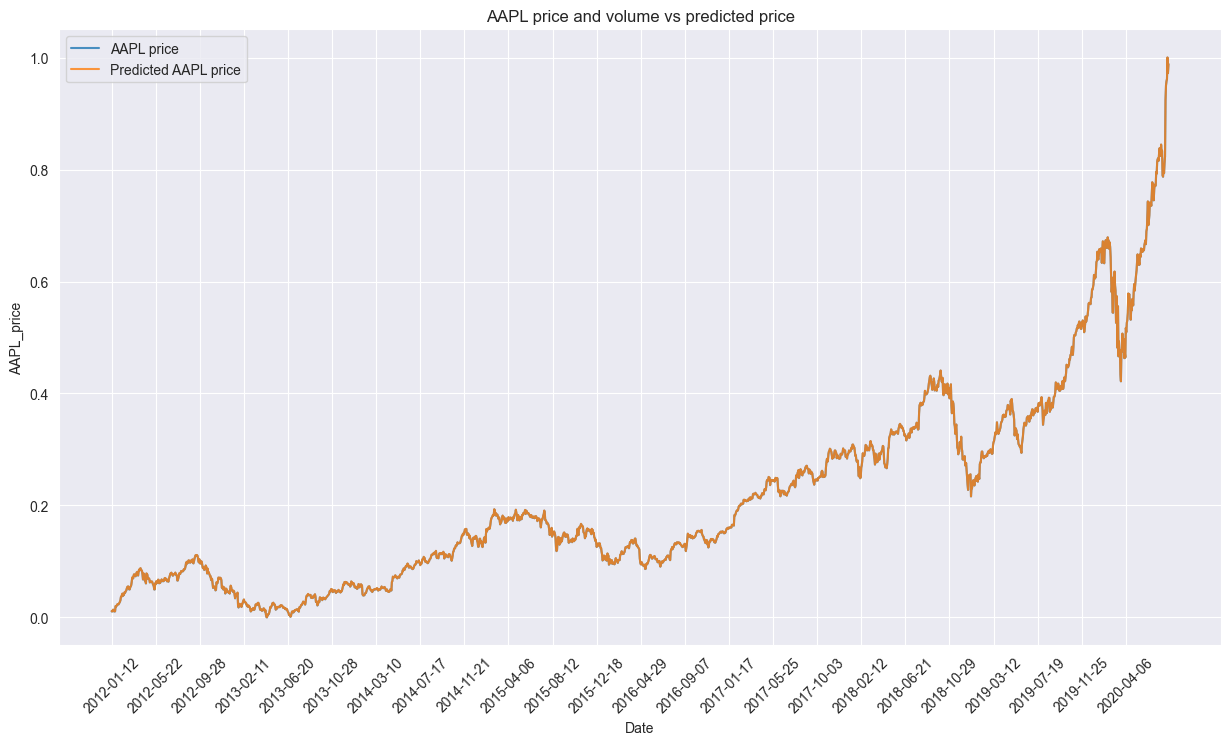

In [124]:
# Plot the results

fig = plt.figure(figsize=(15, 8))
sns.lineplot(x='Date', y='AAPL_price', data=X_sc, label='AAPL price', alpha=0.8)
sns.lineplot(x='Date', y=y_pred.reshape(-1), data=X_sc, label='Predicted AAPL price', alpha=0.8)
plt.title('AAPL price and volume vs predicted price')
plt.xticks(np.arange(0, len(y_pred), step=3*30), rotation=45)
plt.legend()
plt.show()

*Comments*:

The OLS model exhibits a remarkable level of accuracy, as evidenced by the closely aligned predicted and actual prices. The high coefficient of determination (R^2 = 0.99) reflects the model's strong ability to explain nearly all the variance in the predicted prices. The coefficient of the price in particular is really close to one which means it quite surely using the price at the previous time step due to the low variability across days.


### Model for all stocks

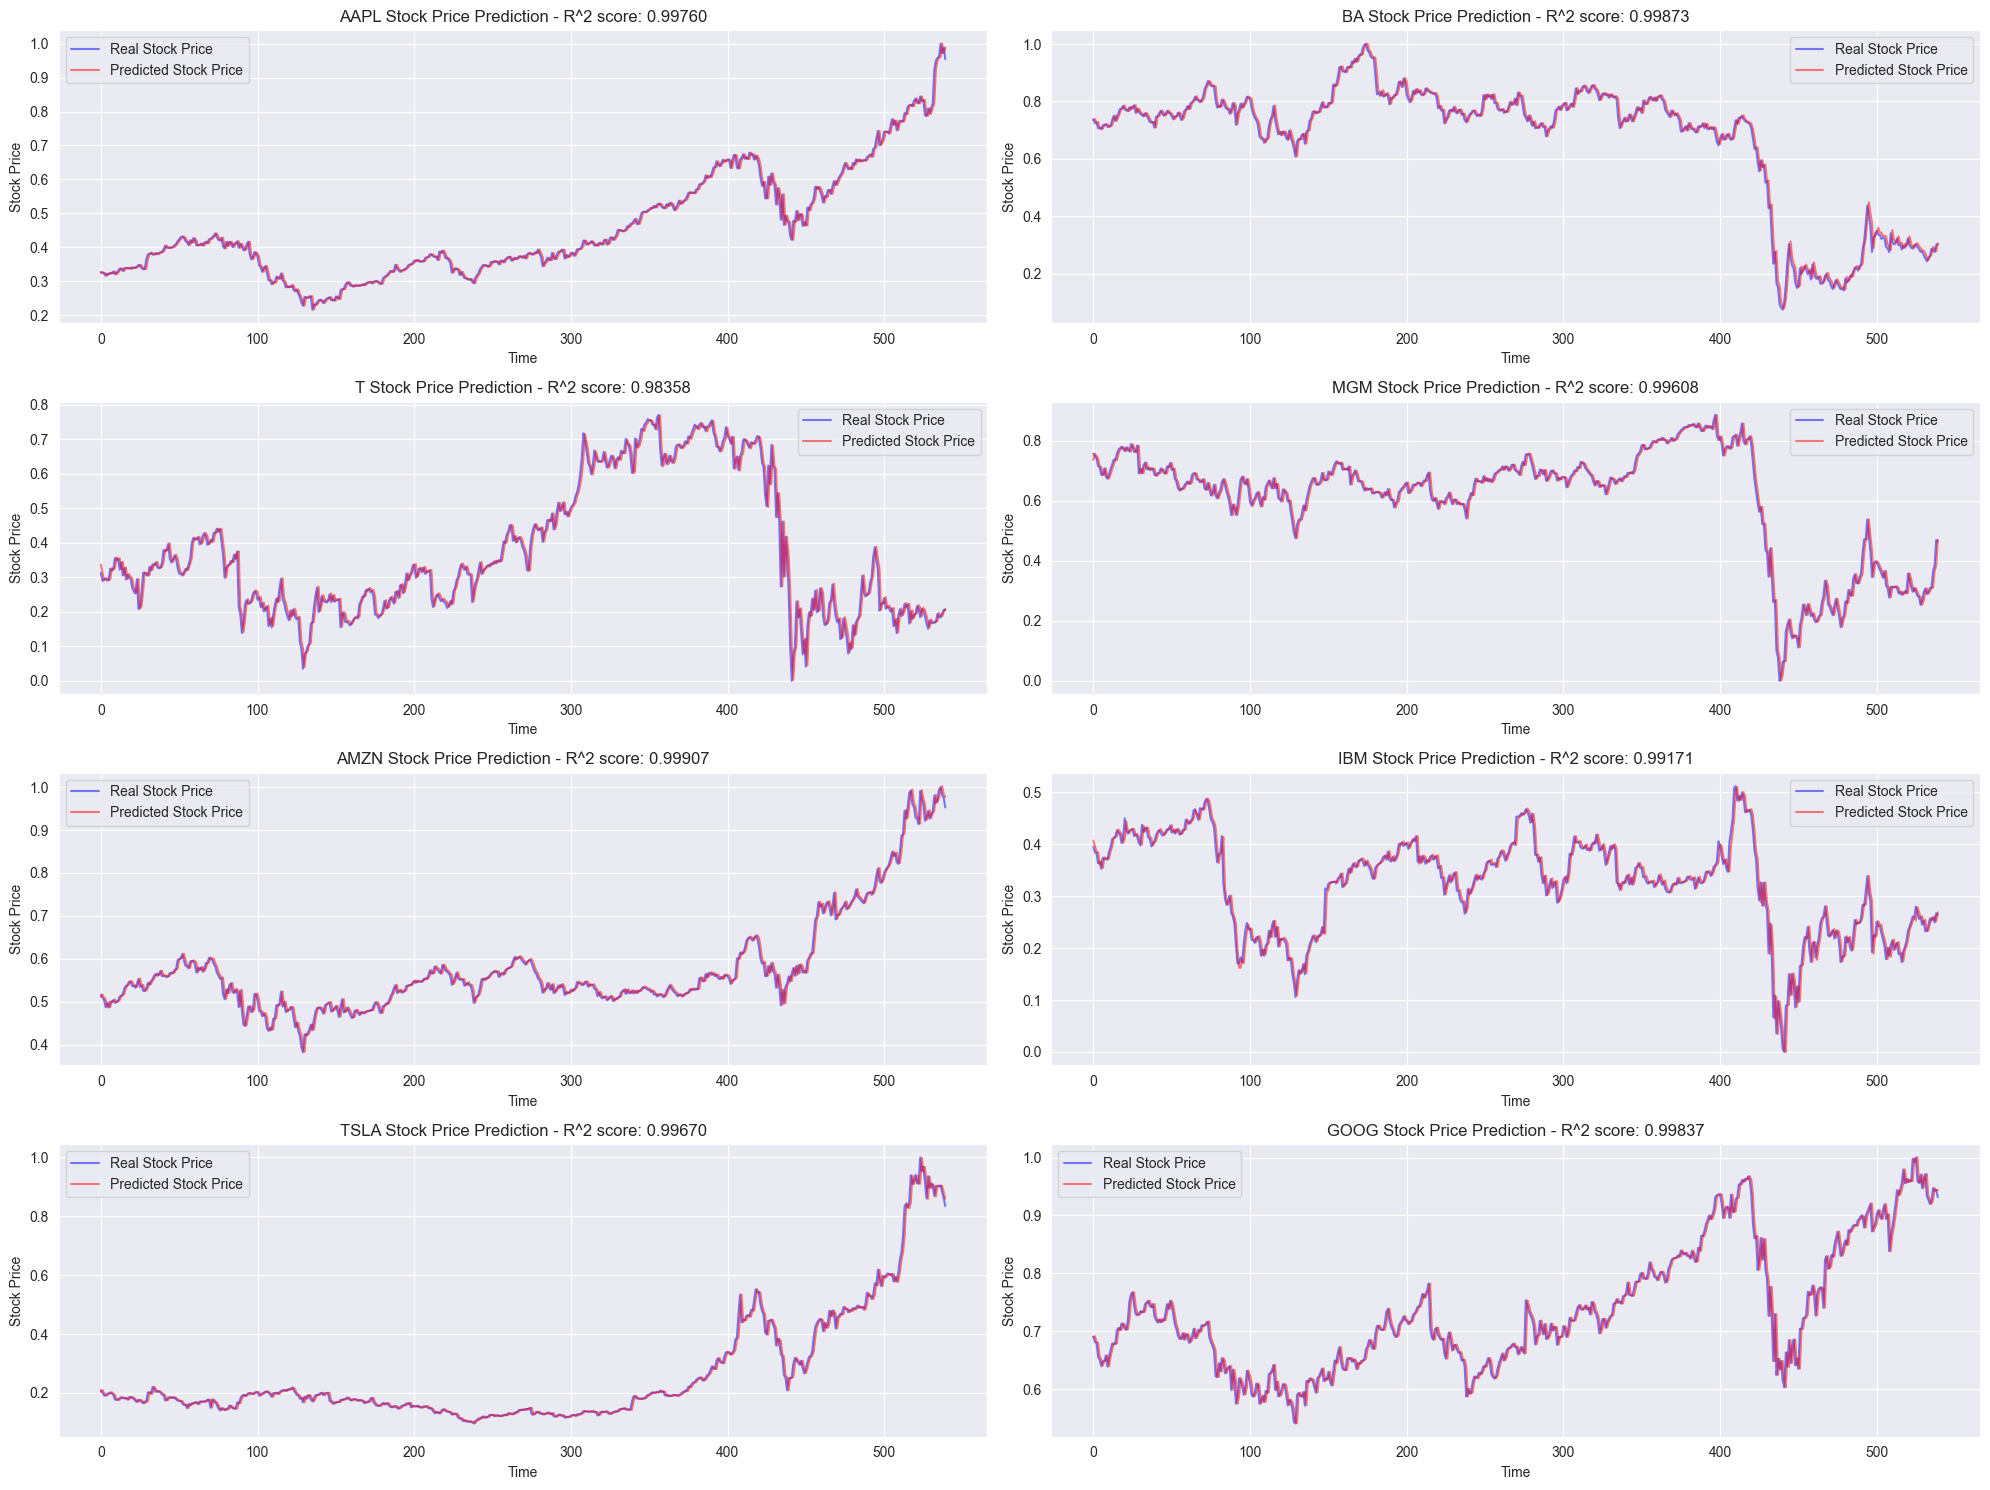

In [161]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

R_oos = []  # List to store the R^2 scores
sign = []   # List to store the sign of the change of price predictions


for stock in stocks:
    row = stocks.get_loc(stock) // 2    # Get the row and column of the subplot
    col = stocks.get_loc(stock) % 2

    stock_df = reg_data[[f'{stock}_price', f'{stock}_volume']]  # Choose the price and volume of the stock
    stock_x = stock_df[:-1]
    stock_y = stock_df[stock+'_price'][1:]

    sc = MinMaxScaler(feature_range = (0, 1))   # Scale the data
    stock_x = sc.fit_transform(stock_x)
    stock_y = sc.fit_transform(stock_y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(stock_x, stock_y, test_size=0.25, shuffle=False)

    regressor = LinearRegression()  # Create and train an ols model
    regressor.fit(X_train, y_train)

    y_pred = regressor.predict(X_test)  # Predict the test set results

    R_oos.append(1 - np.sum((y_test - y_pred)**2) / np.sum(y_test**2))
    sign.append(np.sum([1 if np.sign(y_pred[i+1] - y_test[i]) == np.sign(y_test[i+1] - y_test[i]) else 0 for i in range(len(y_test)-1)])/len(y_test))    # Count the number of times the sign of the change is correct

    axes[row, col].plot(list(y_test), color='blue', label='Real Stock Price', alpha=0.5)
    axes[row, col].plot(y_pred, color='red', label='Predicted Stock Price', alpha=0.5)
    axes[row, col].set_title(f'{stock} Stock Price Prediction - R^2 score: {regressor.score(X_train, y_train):.5f}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

- Create and train a Ridge linear regression model (and play with the penalty parameter)

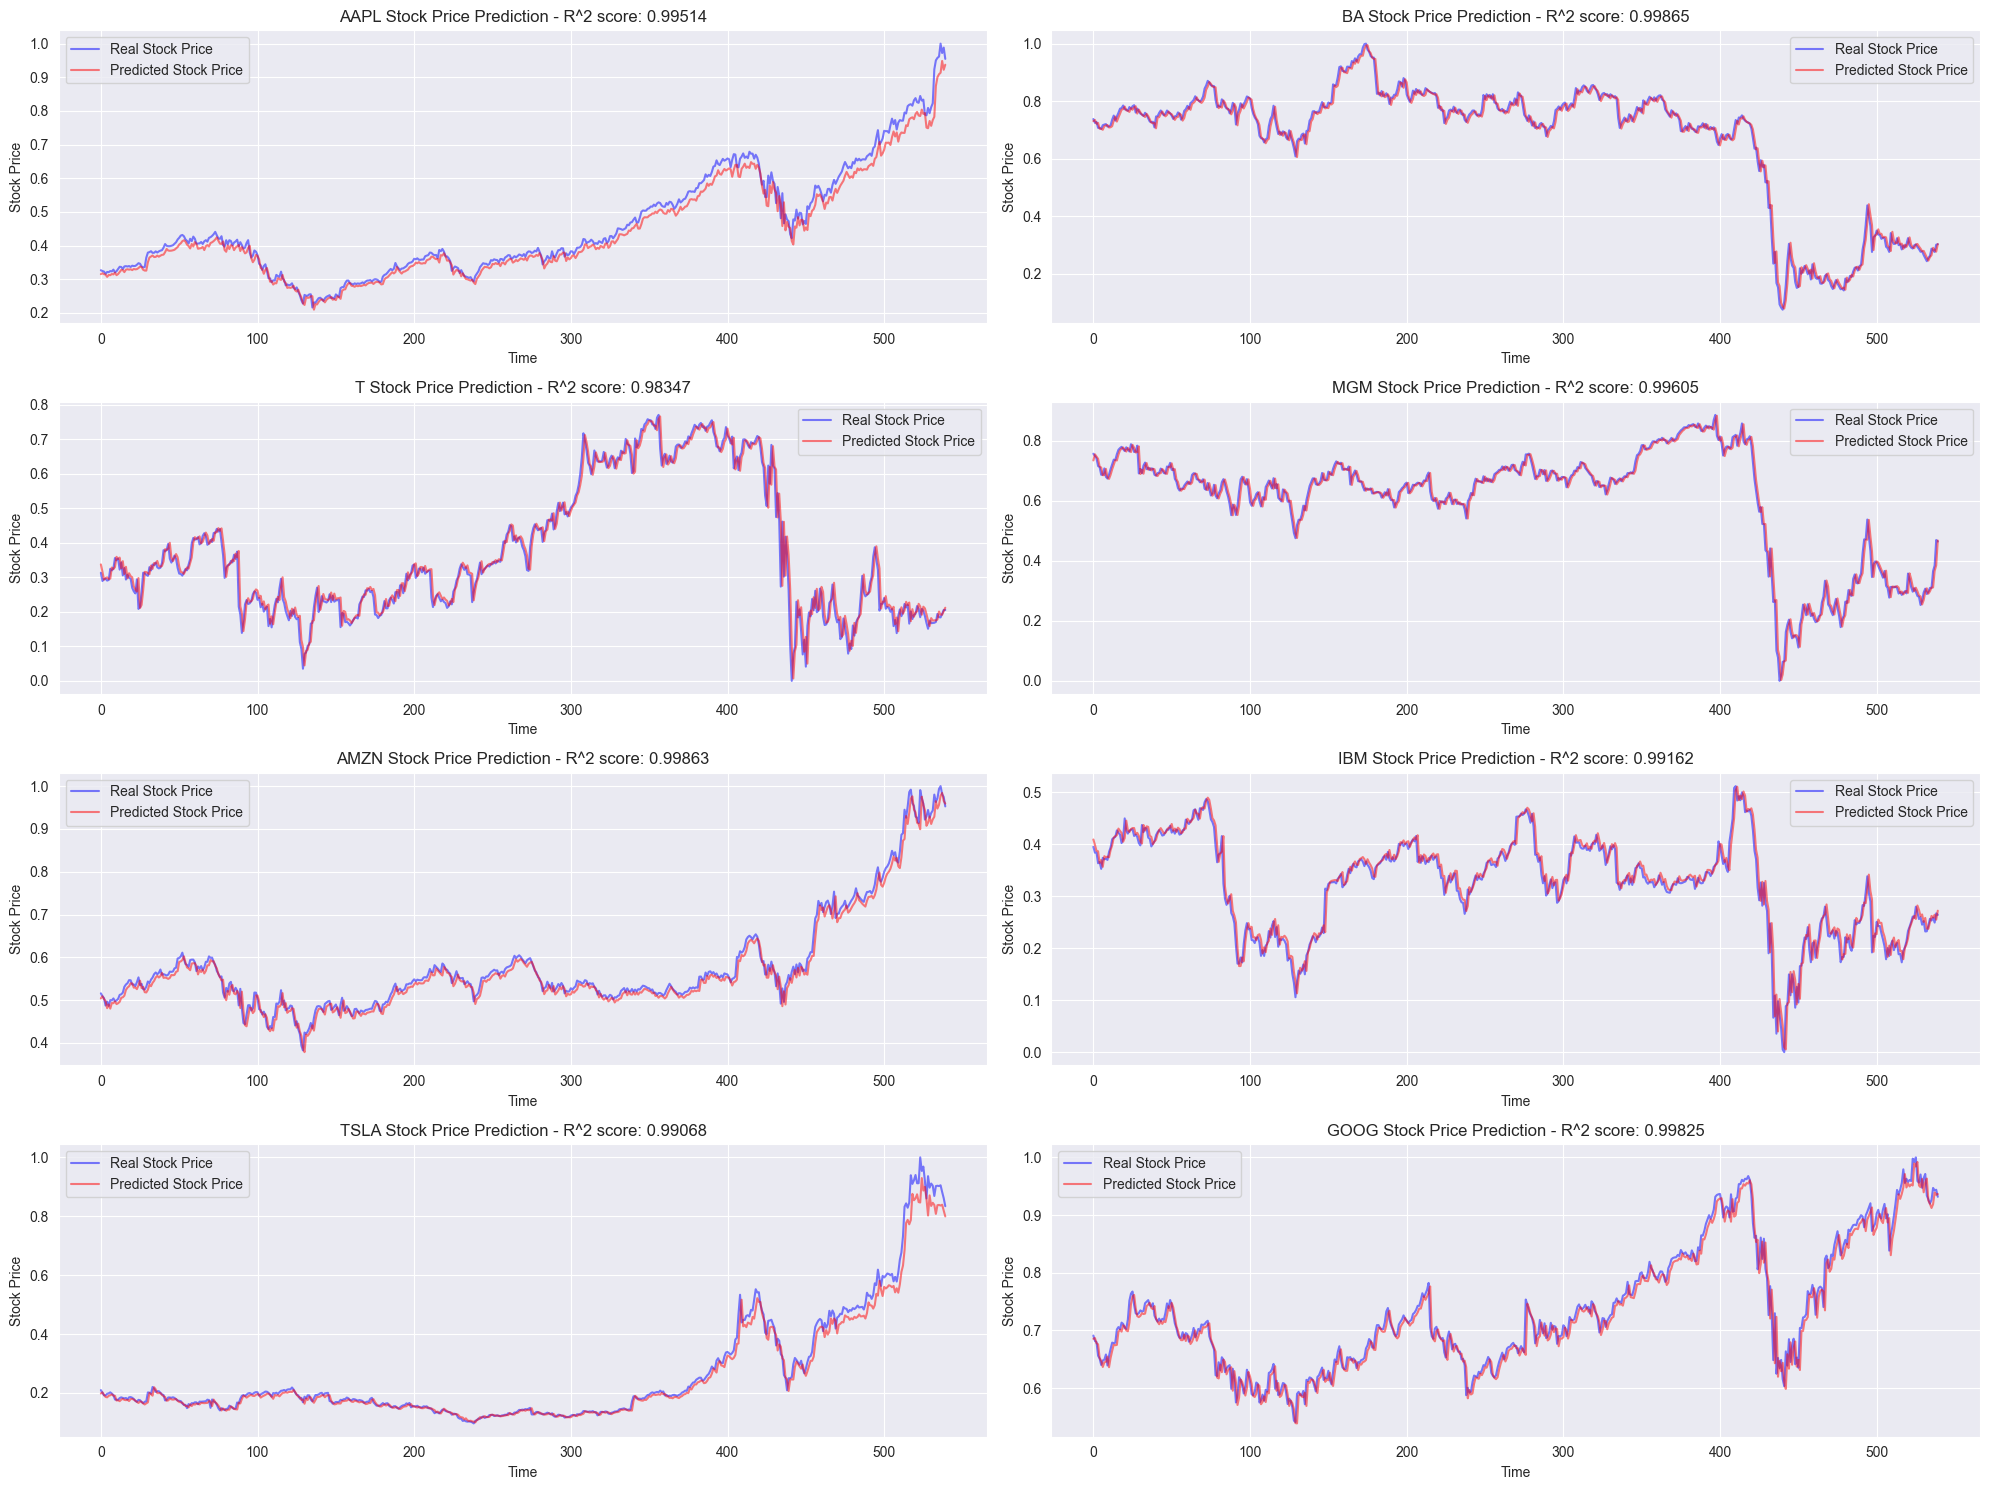

In [162]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

R_oos_ridge_05 = []
sign_ridge_05 = []

for stock in stocks:
    row = stocks.get_loc(stock) // 2
    col = stocks.get_loc(stock) % 2

    stock_df = reg_data[[f'{stock}_price', f'{stock}_volume']]
    stock_x = stock_df[:-1]
    stock_y = stock_df[stock+'_price'][1:]

    # Scale the data
    sc = MinMaxScaler(feature_range = (0, 1))
    stock_x = sc.fit_transform(stock_x)
    stock_y = sc.fit_transform(stock_y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(stock_x, stock_y, test_size=0.25, shuffle=False)

    regressor_ridge = Ridge(alpha=0.5)
    regressor_ridge.fit(X_train, y_train)

    y_pred = regressor_ridge.predict(X_test)

    R_oos_ridge_05.append(1 - np.sum((y_test - y_pred)**2)/np.sum(y_test**2))
    sign_ridge_05.append(np.sum([1 if np.sign(y_pred[i+1] - y_test[i]) == np.sign(y_test[i+1] - y_test[i]) else 0 for i in range(len(y_test)-1)])/len(y_test))    # Count the number of times the sign of the change is correct

    axes[row, col].plot(list(y_test), color='blue', label='Real Stock Price', alpha=0.5)
    axes[row, col].plot(y_pred, color='red', label='Predicted Stock Price', alpha=0.5)
    axes[row, col].set_title(f'{stock} Stock Price Prediction - R^2 score: {regressor_ridge.score(X_train, y_train):.5f}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

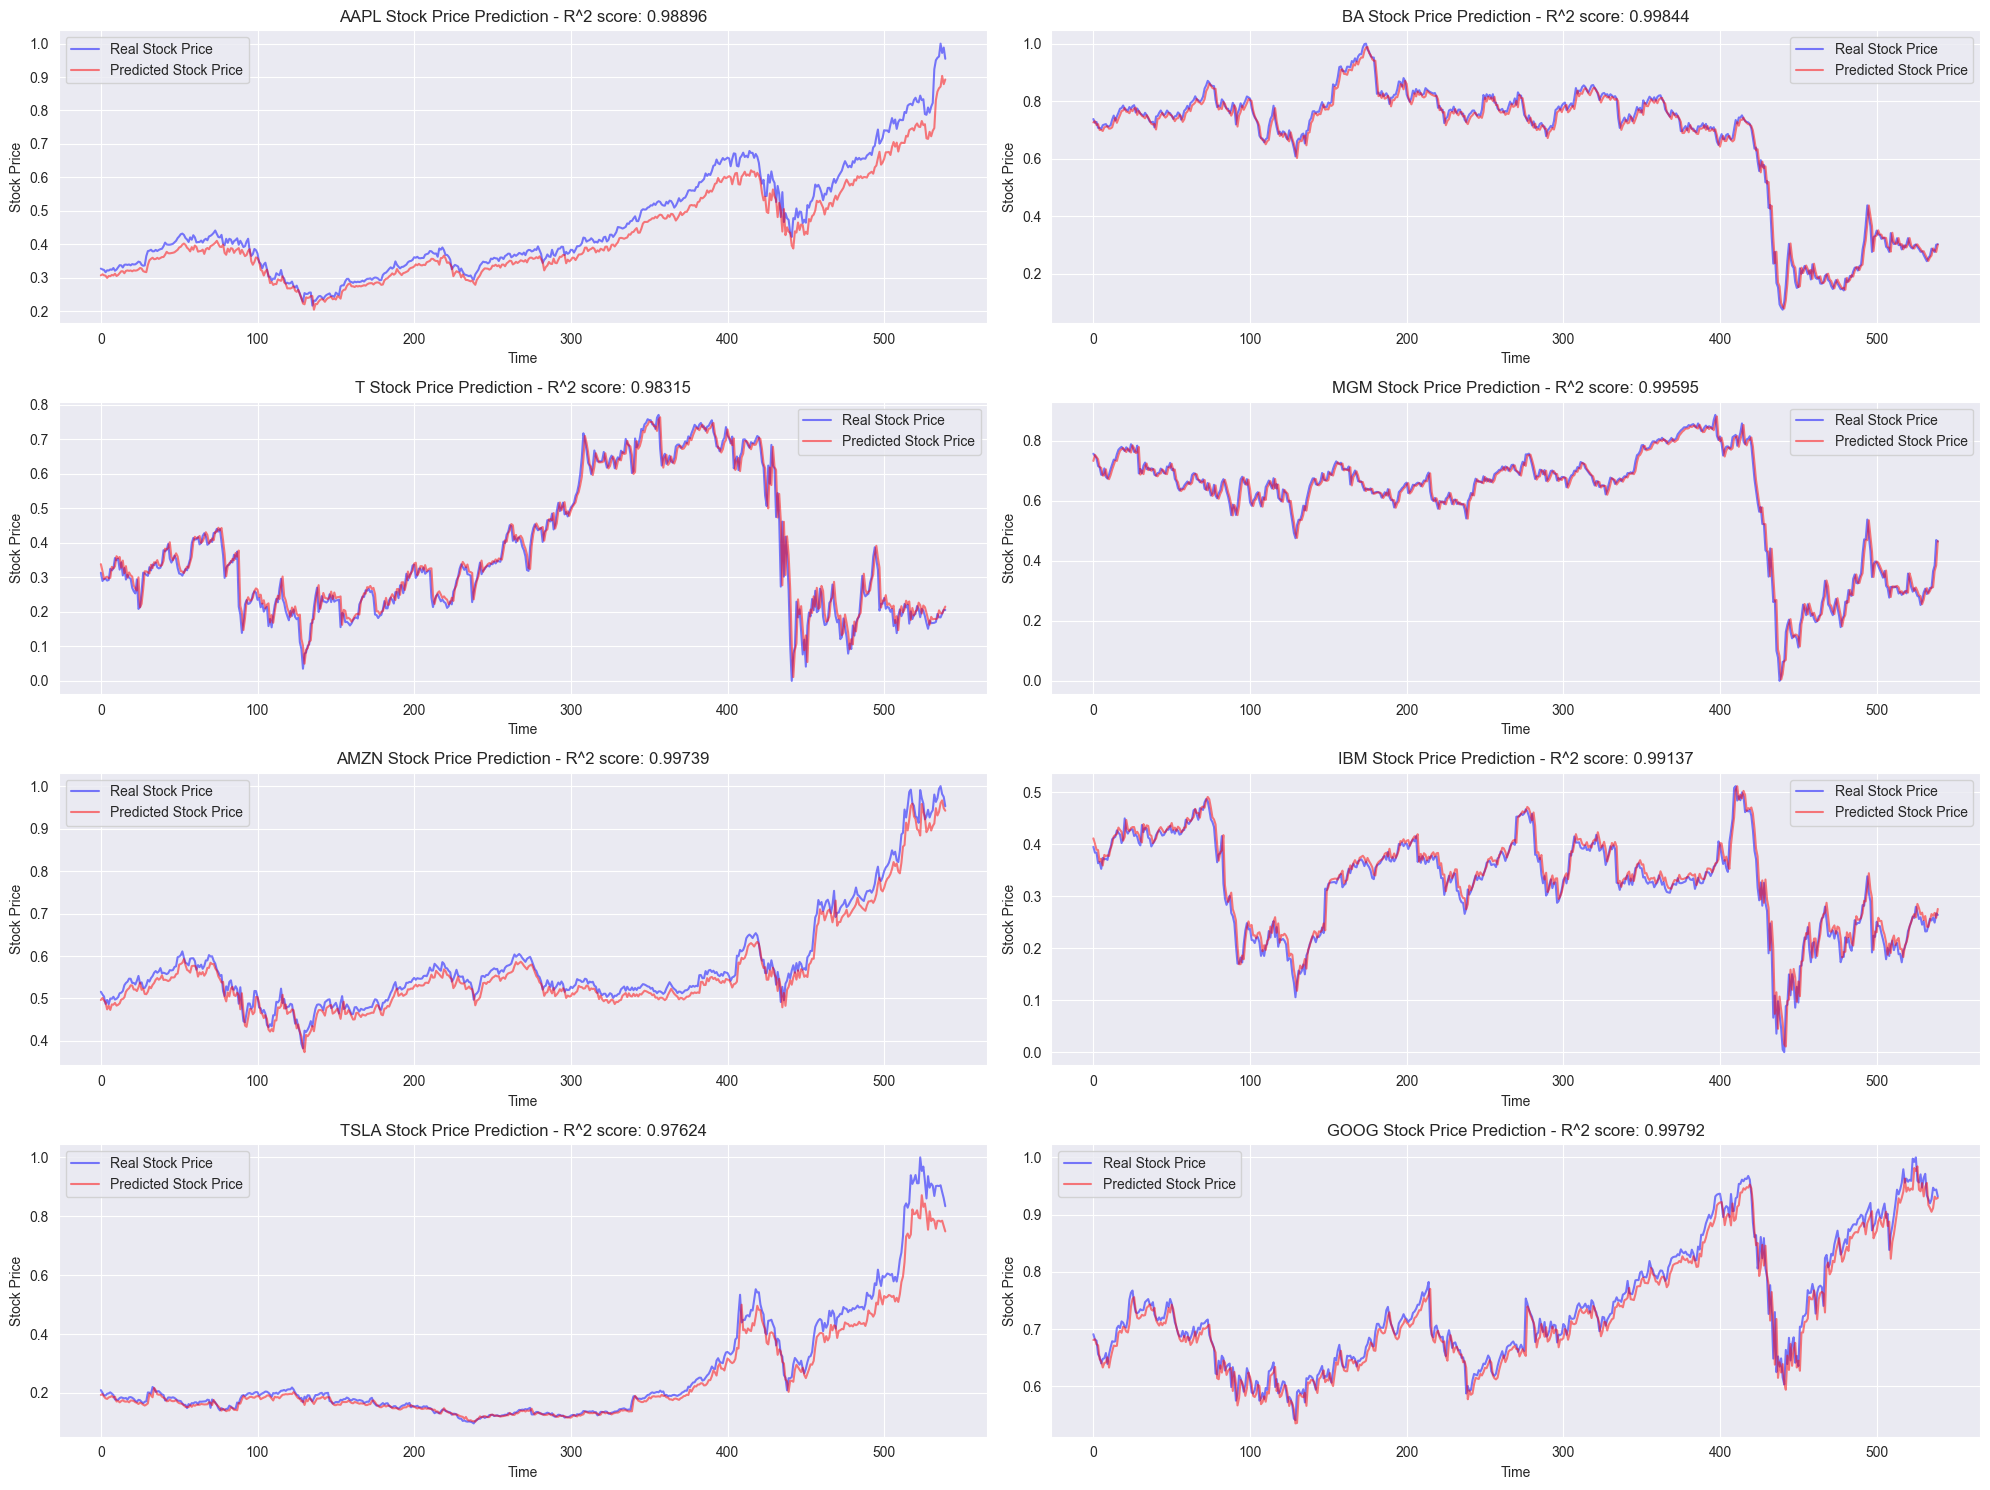

In [163]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

R_oos_ridge_1 = []
sign_ridge_1 = []

for stock in stocks:
    row = stocks.get_loc(stock) // 2
    col = stocks.get_loc(stock) % 2

    stock_df = reg_data[[f'{stock}_price', f'{stock}_volume']]
    stock_x = stock_df[:-1]
    stock_y = stock_df[stock+'_price'][1:]

    sc = MinMaxScaler(feature_range = (0, 1))   # Scale the data
    stock_x = sc.fit_transform(stock_x)
    stock_y = sc.fit_transform(stock_y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(stock_x, stock_y, test_size=0.25, shuffle=False)

    regressor_ridge = Ridge(alpha=1)
    regressor_ridge.fit(X_train, y_train)

    y_pred = regressor_ridge.predict(X_test)

    R_oos_ridge_1.append(1 - np.sum((y_test - y_pred)**2)/np.sum(y_test**2))
    sign_ridge_1.append(np.sum([1 if np.sign(y_pred[i+1] - y_test[i]) == np.sign(y_test[i+1] - y_test[i]) else 0 for i in range(len(y_test)-1)])/len(y_test))    # Count the number of times the sign of the change is correct

    axes[row, col].plot(list(y_test), color='blue', label='Real Stock Price', alpha=0.5)
    axes[row, col].plot(y_pred, color='red', label='Predicted Stock Price', alpha=0.5)
    axes[row, col].set_title(f'{stock} Stock Price Prediction - R^2 score: {regressor_ridge.score(X_train, y_train):.5f}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

- What is the $R_{OOS}$ of the 2 methods ?

In [133]:
# Plot the R^2 scores

fig = go.Figure()

fig.add_trace(go.Scatter(x=stocks,
                        y=R_oos,
                        marker_color='lightgreen',
                        name='OLS'))

fig.add_trace(go.Scatter(x=stocks,
                        y=R_oos_ridge_05,
                        marker_color='lightcoral',
                        name='Ridge 0.5'))

fig.add_trace(go.Scatter(x=stocks,
                        y=R_oos_ridge_1,
                        marker_color='lightblue',
                        name='Ridge 1'))

fig.update_layout(title='R^2 scores of the models',
                        xaxis_title='Stocks',
                        yaxis_title='R^2 score')

fig.show()

- Alternative measures: number of time the predicted return and the realized return have the same sign (or MSE, R-square)

In [164]:
# Plot the sign scores

fig = go.Figure()

fig.add_trace(go.Scatter(x=stocks,
                        y=sign,
                        marker_color='lightgreen',
                        name='OLS'))

fig.add_trace(go.Scatter(x=stocks,
                        y=sign_ridge_05,
                        marker_color='lightcoral',
                        name='Ridge 0.5'))

fig.add_trace(go.Scatter(x=stocks,
                        y=sign_ridge_1,
                        marker_color='lightblue',
                        name='Ridge 1'))

fig.update_layout(title='"Sign" scores of the models',
                        xaxis_title='Stocks',
                        yaxis_title='Correctness score')

fig.show()

Comments

In our quest to refine and augment our predictive modeling capabilities, we tried  Ridge Regression. Building upon our initial OLS (Ordinary Least Squares) model, we recognized the importance of managing potential overfitting. However, the application of Ridge Regression didn't have any impactful effect on our model. If we blindly look at the R2 regarding the different model setting we see that the different ridge setting that we tried had worse performances compared to the standard OLS. The latter is expectable since ridge is mainly used to decrease the coefficient of the less relevant predictors (making it close to 0) in high dimensional data, which is not the case since we are only levering the price at the previous time step and the volume (which has a really low coefficient in this case).

# Optional Task #2 bis
## *Improving the model?*

- What about including the market (and being closer to the theory) ?
$$P_{i,t+1} = f(P_{i,t}, V_{i,t}, P_{M,t})$$

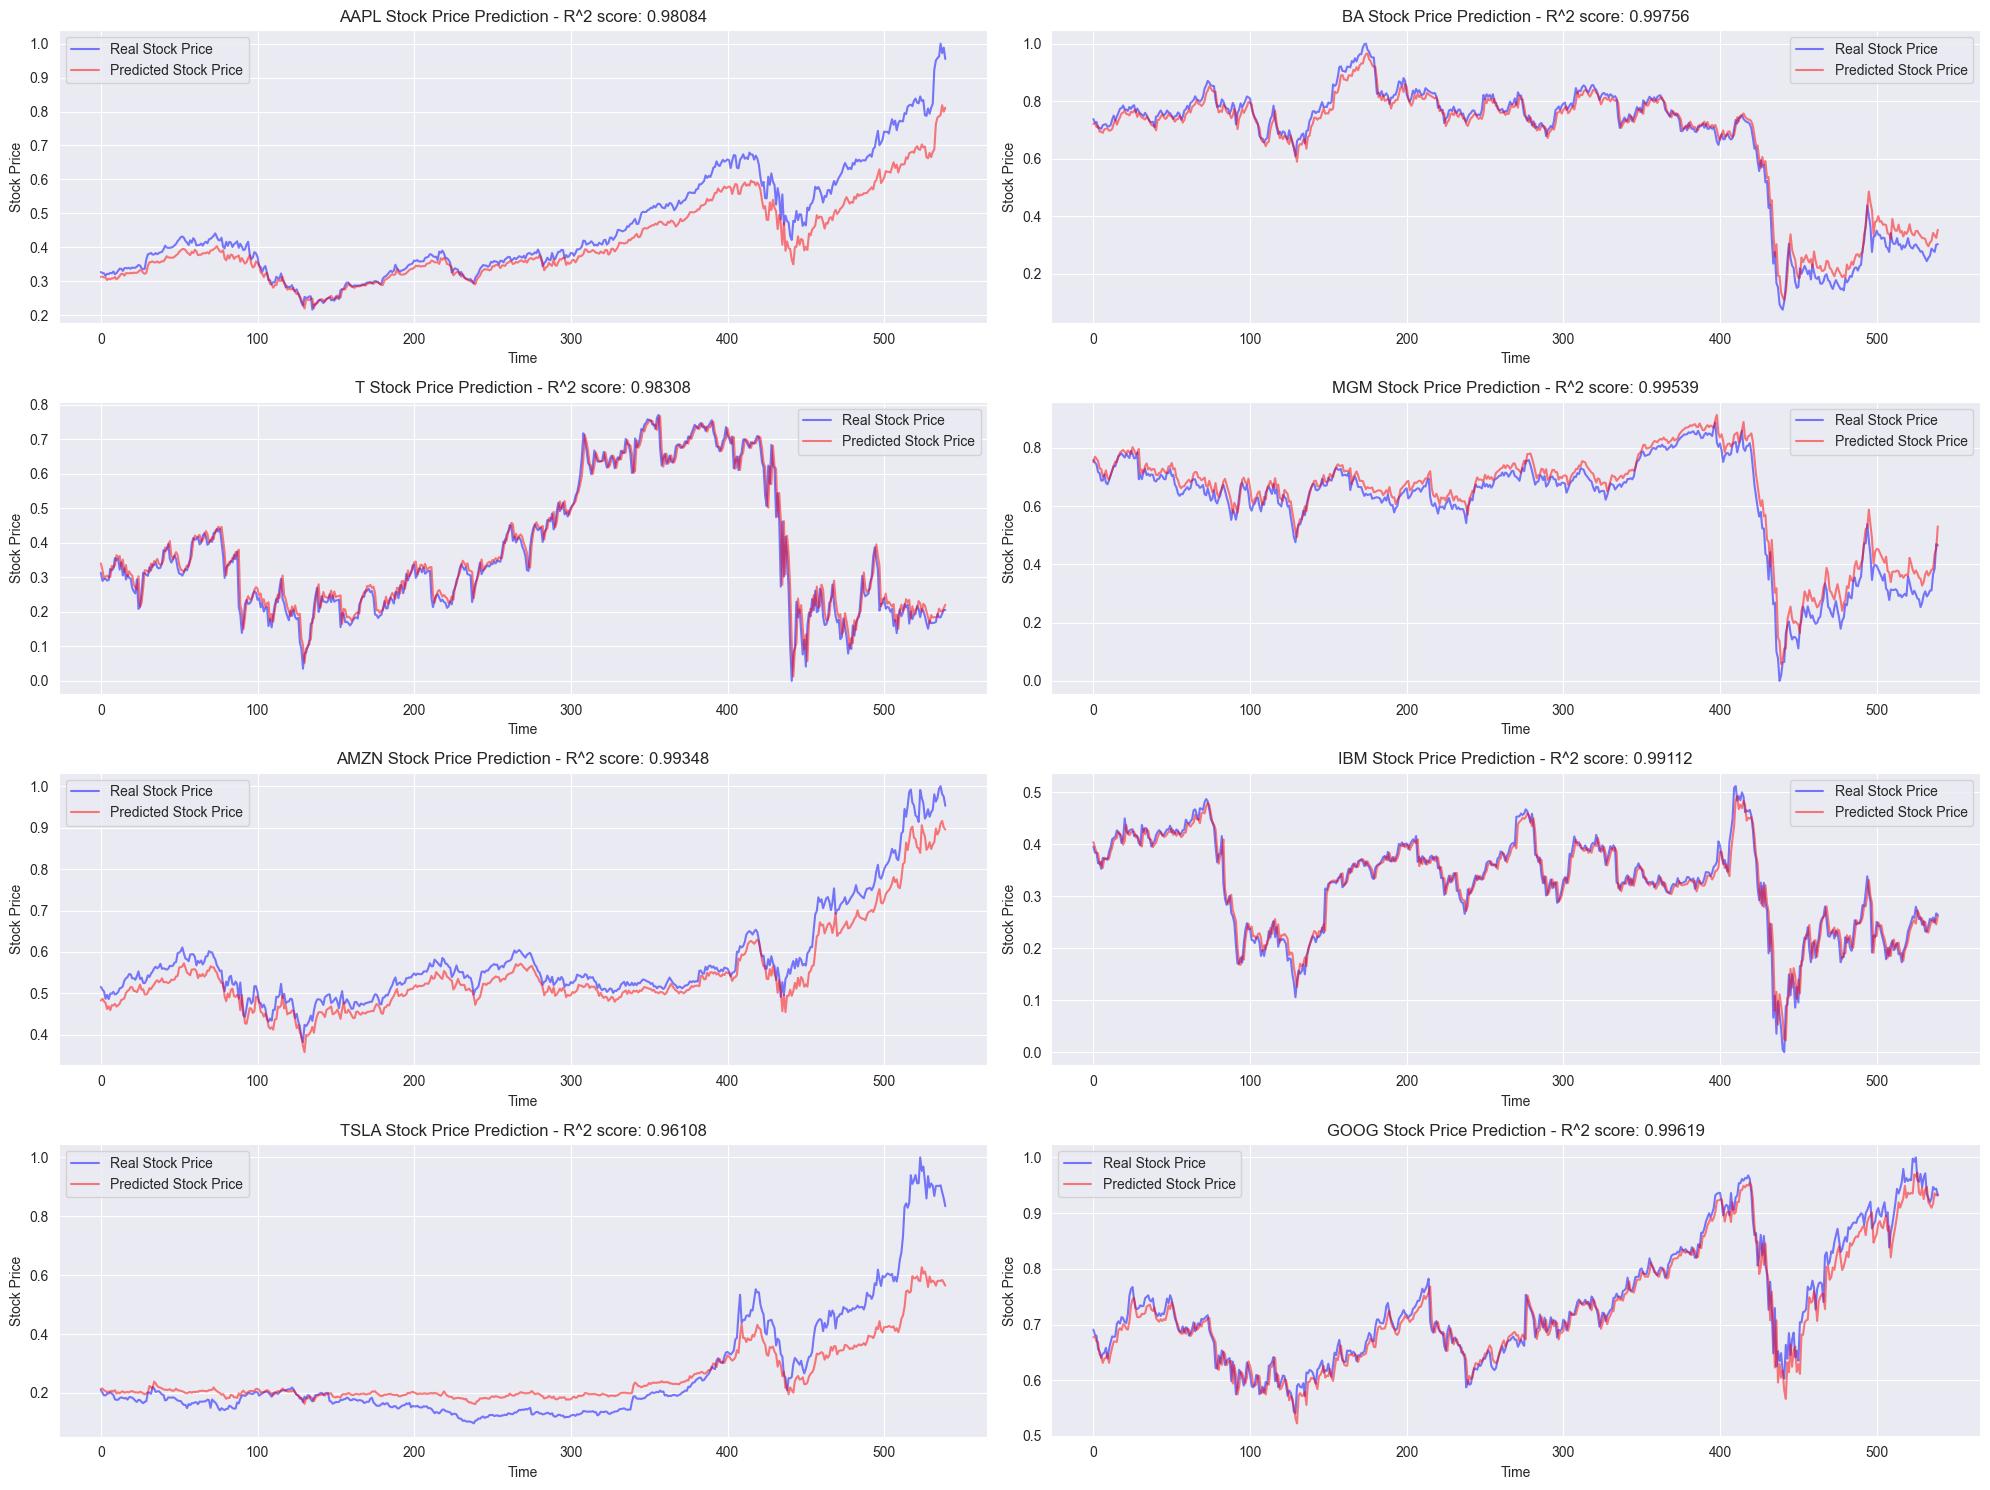

In [165]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

R_oos_ridge_1_mkt = []
sign_ridge_1_mkt = []

for stock in stocks:
    row = stocks.get_loc(stock) // 2
    col = stocks.get_loc(stock) % 2

    stock_df = reg_data[[f'{stock}_price', f'{stock}_volume', 'sp500_price']]
    stock_x = stock_df[:-1]
    stock_y = stock_df[stock+'_price'][1:]

    # Scale the data
    sc = MinMaxScaler(feature_range = (0, 1))
    stock_x = sc.fit_transform(stock_x)
    stock_y = sc.fit_transform(stock_y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(stock_x, stock_y, test_size=0.25, shuffle=False)

    regressor_ridge = Ridge(alpha=1)
    regressor_ridge.fit(X_train, y_train)

    y_pred = regressor_ridge.predict(X_test)

    R_oos_ridge_1_mkt.append(1 - np.sum((y_test - y_pred)**2)/np.sum(y_test**2))
    sign_ridge_1_mkt.append(np.sum([1 if np.sign(y_pred[i+1] - y_test[i]) == np.sign(y_test[i+1] - y_test[i]) else 0 for i in range(len(y_test)-1)])/len(y_test))    # Count the number of times the sign of the change is correct

    axes[row, col].plot(list(y_test), color='blue', label='Real Stock Price', alpha=0.5)
    axes[row, col].plot(y_pred, color='red', label='Predicted Stock Price', alpha=0.5)
    axes[row, col].set_title(f'{stock} Stock Price Prediction - R^2 score: {regressor_ridge.score(X_train, y_train):.5f}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

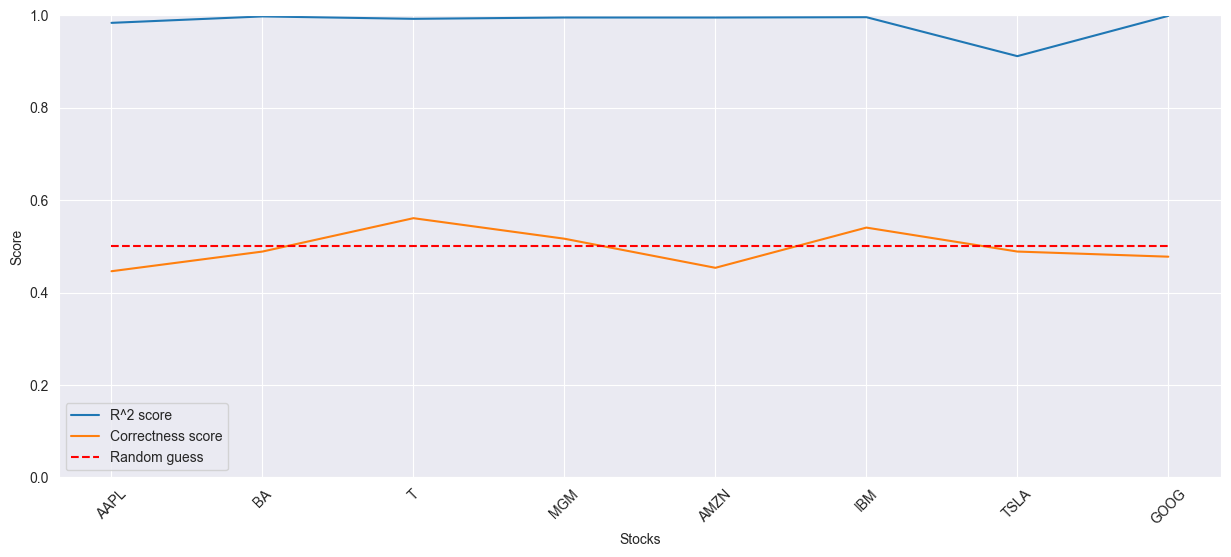

In [176]:
# Plot the R^2 scores and the correctness scores

fig = plt.figure(figsize=(15, 6))
plt.plot(stocks, R_oos_ridge_1_mkt, label='R^2 score')
plt.plot(stocks, sign_ridge_1_mkt, label='Correctness score')
plt.plot(stocks, [0.5]*len(stocks), label='Random guess', color='red', linestyle='--')
plt.xticks(np.arange(0, len(stocks), step=1), labels=stocks, rotation=45)
plt.xlabel('Stocks')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

- What about including more lags?
$$P_{i,t+1} = f (P_{i,t}, V_{i,t}, P_{M,t}, P_{i,t−1}, P_{i,t−2})$$

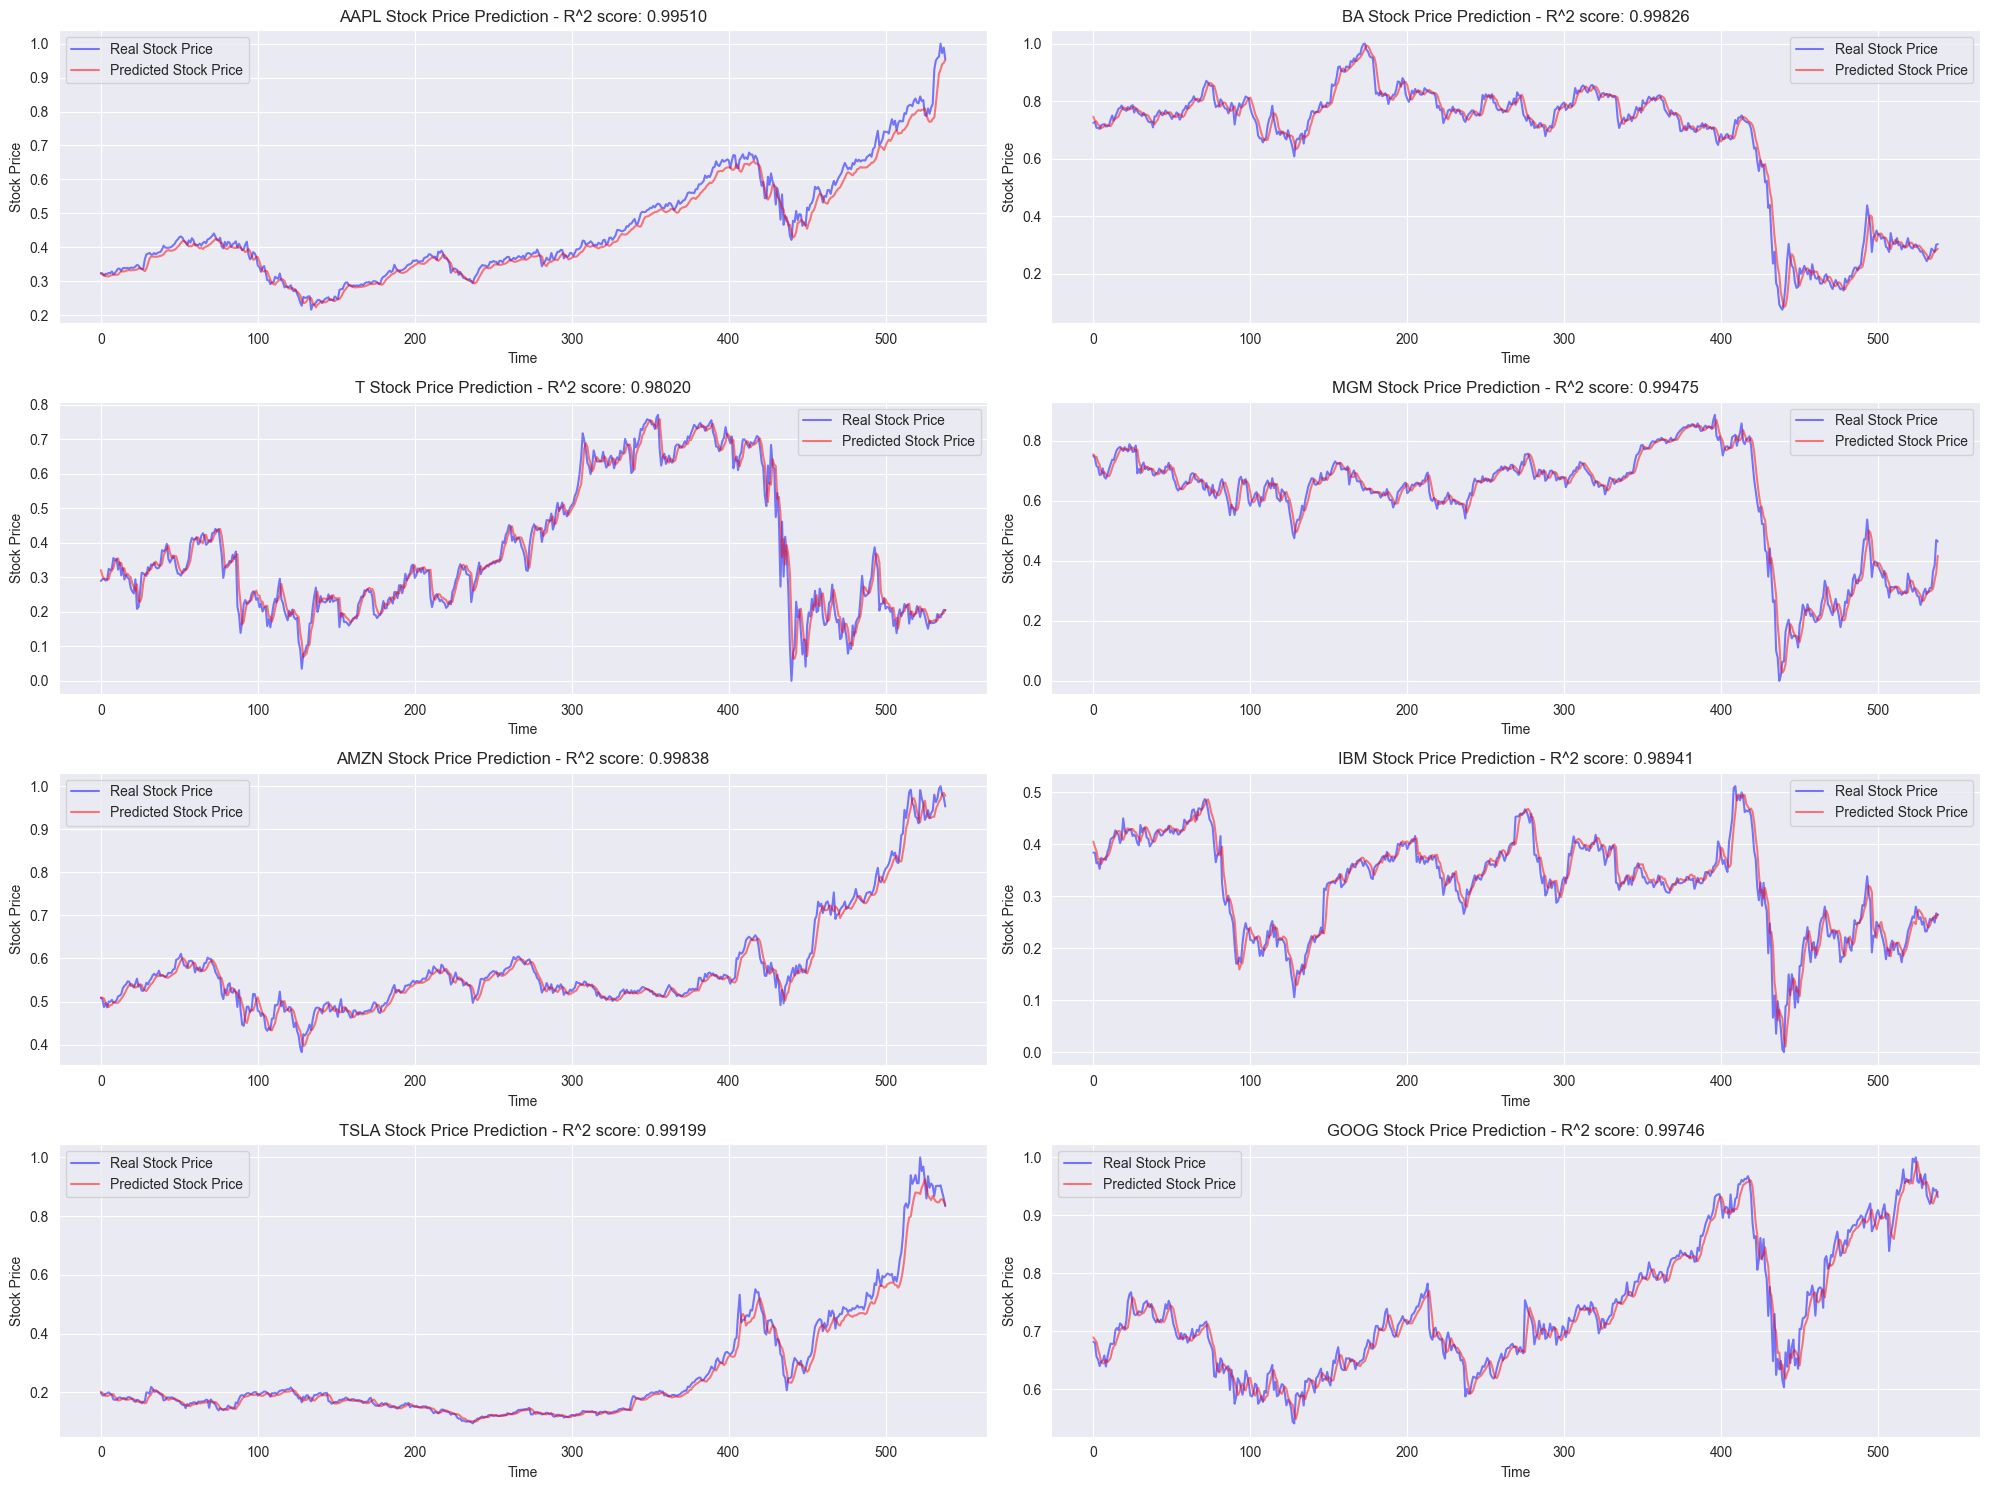

In [178]:
fig, axes = plt.subplots(4, 2, figsize=(20, 15))

R_oos_ridge_1_lags = []
sign_ridge_1_lags = []

for stock in stocks:
    row = stocks.get_loc(stock) // 2
    col = stocks.get_loc(stock) % 2

    lag_1 = reg_data[[f'{stock}_price']].shift(1).rename(columns={f'{stock}_price': f'{stock}_price_lag_1'})
    lag_2 = reg_data[[f'{stock}_price']].shift(2).rename(columns={f'{stock}_price': f'{stock}_price_lag_2'})

    stock_df =  pd.concat([reg_data[[f'{stock}_price', f'{stock}_volume']], lag_1, lag_2], axis=1)[2:]
    stock_x = stock_df[:-1]
    stock_y = stock_df[stock+'_price'][1:]

    # Scale the data
    sc = MinMaxScaler(feature_range = (0, 1))
    stock_x = sc.fit_transform(stock_x)
    stock_y = sc.fit_transform(stock_y.values.reshape(-1, 1))

    X_train, X_test, y_train, y_test = train_test_split(stock_x, stock_y, test_size=0.25, shuffle=False)

    regressor_ridge = Ridge(alpha=1)
    regressor_ridge.fit(X_train, y_train)

    y_pred = regressor_ridge.predict(X_test)

    R_oos_ridge_1_lags.append(1 - np.sum((y_test - y_pred)**2)/np.sum(y_test**2))
    sign_ridge_1_lags.append(np.sum(np.sign(np.diff(y_pred)) == np.sign(np.diff(list(y_test)))) / (len(y_pred) - 1))    # Count the number of times the sign of the change is correct

    axes[row, col].plot(list(y_test), color='blue', label='Real Stock Price', alpha=0.5)
    axes[row, col].plot(y_pred, color='red', label='Predicted Stock Price', alpha=0.5)
    axes[row, col].set_title(f'{stock} Stock Price Prediction - R^2 score: {regressor_ridge.score(X_train, y_train):.5f}')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel('Stock Price')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

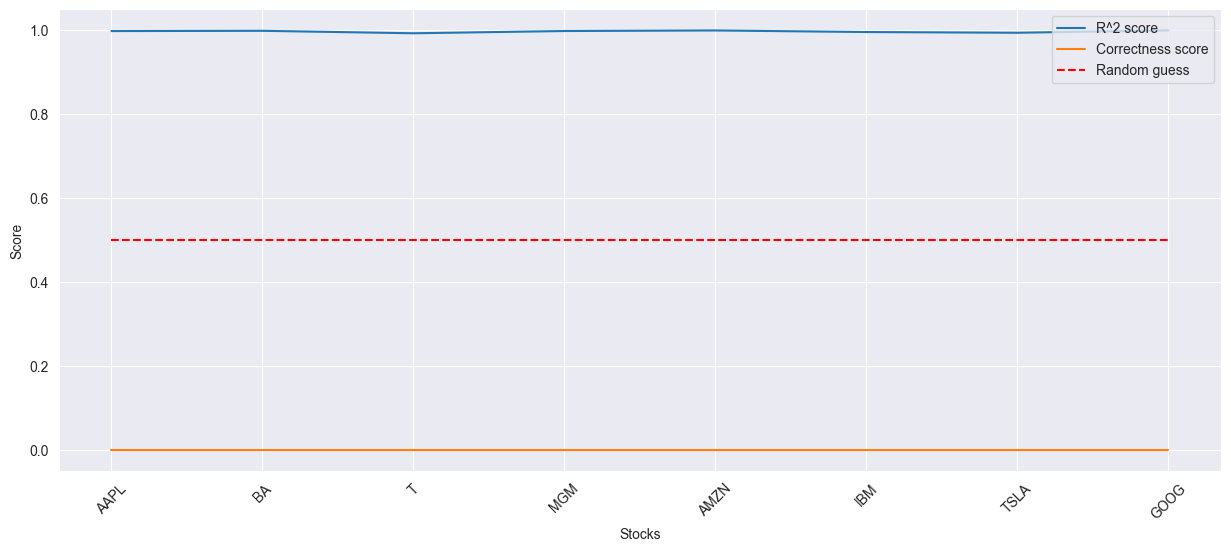

In [179]:
# Plot the R^2 scores and the correctness scores

fig = plt.figure(figsize=(15, 6))
plt.plot(stocks, R_oos_ridge_1_lags, label='R^2 score')
plt.plot(stocks, sign_ridge_1_lags, label='Correctness score')
plt.plot(stocks, [0.5]*len(stocks), label='Random guess', color='red', linestyle='--')
plt.xticks(np.arange(0, len(stocks), step=1), labels=stocks, rotation=45)
plt.xlabel('Stocks')
plt.ylabel('Score')
plt.legend()
plt.show()

Including more lags doesn't improve the model. The reason is that the price at time t is already a function of the price at time t-1 and t-2. So including them in the model doesn't add any new information.

Also, the *sign* score is 0 for all the stocks, meaning that the predictions are always wrong.

# Task #3
## *Same but with NN or Trees*

- Pick one (or several) machine learning model: e.g., NN with many layers and repeat the same steps as Task #2

In [180]:
def stock_df(df, stock, n = 1):
    '''
    This function creates a dataframe with the stock price and volume and the target variable
    ----------------------------
    df = dataframe
    stock = stock name
    n = number of lags + current
    '''

    df = df[['Date', stock+'_price', stock+'_volume']].copy()


    df['target'] = df[stock+'_price'].shift(-1)
    df.dropna(inplace=True)
    df.rename(columns={stock+'_price': 'price', stock+'_volume': 'volume'}, inplace=True)
    df = df.drop(['Date'], axis=1)
    
    return df

In [181]:
# Scale the data

aapl = stock_df(reg_data, 'AAPL')
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
aapl_scaled = aapl.copy()
aapl_scaled[['price', 'volume']] = scaler_x.fit_transform(aapl_scaled[['price', 'volume']])
aapl_scaled['target'] = scaler_y.fit_transform(aapl_scaled[['target']])
aapl_scaled = np.array(aapl_scaled)

### Comments on scaling

While we adhered to a comprehensive scaling process to maintain coherence with the lab assignment and to achieve results more aligned with the example assignment, we are still puzzled by the data leakage caused by applying MinMax scaling to the entire dataset before splitting it into training and test sets. The correct procedure should ideally involve scaling after the split, using only the training data for this purpose. However, even in this scenario, the MinMax scaler might lose its practicality, especially in time series data, particularly those related to unbounded variables like stock prices, where it's highly likely that the test data would exceed the value of 1. This prompts consideration of an alternative scaling approach, one that is not constrained by boundedness and could potentially produce more advantageous results.

In [182]:
def input_ts(df, steps=1, features=2):
    '''
    The function splits the data into X and y, where X is the number of lags + currents and y is the target
    ----------------------------------
    input time series data
    df = dataframe
    steps = number of lags + current
    features = number of features
    '''
    X = np.array([df[i-steps:i, :features].copy() for i in range(steps, len(df))])
    y = np.array(df[steps:, -1])
    
    return X, y

In [183]:
steps = 5
X, y = input_ts(aapl_scaled, steps=steps, features=2)
print(X.shape, y.shape)

(2153, 5, 2) (2153,)


In [184]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(1722, 5, 2) (1722,) (431, 5, 2) (431,)


### LSTM 1 with 5 data points per sample unit

In [207]:
lstm_input = Input(shape=(steps, 2), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
dense = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(dense)

model = Model(inputs=lstm_input, outputs=output, name='LSTM')
adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 5, 2)]            0         
                                                                 
 first_layer (LSTM)          (None, 150)               91800     
                                                                 
 dense_layer (Dense)         (None, 1)                 151       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 91,951
Trainable params: 91,951
Non-trainable params: 0
_________________________________________________________________


In [208]:
model.fit(x=x_train, y=y_train, batch_size=16, epochs=20, shuffle=True, validation_split = 0.1)

Epoch 1/20
97/97 [==============================] - 6s 16ms/step - loss: 0.0010 - accuracy: 6.4558e-04 - val_loss: 3.2590e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
97/97 [==============================] - 1s 7ms/step - loss: 6.1080e-05 - accuracy: 6.4558e-04 - val_loss: 2.5892e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
97/97 [==============================] - 1s 6ms/step - loss: 6.1150e-05 - accuracy: 6.4558e-04 - val_loss: 3.2801e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
97/97 [==============================] - 1s 7ms/step - loss: 5.7827e-05 - accuracy: 6.4558e-04 - val_loss: 2.4096e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
97/97 [==============================] - 1s 6ms/step - loss: 6.6061e-05 - accuracy: 6.4558e-04 - val_loss: 2.8077e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
97/97 [==============================] - 1s 6ms/step - loss: 6.9549e-05 - accuracy: 6.4558e-04 - val_loss: 2.3472e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
97/97 [==============================] - 1s 6ms/step - l

In [209]:
y_pred = model.predict(X)

68/68 [==============================] - 1s 4ms/step


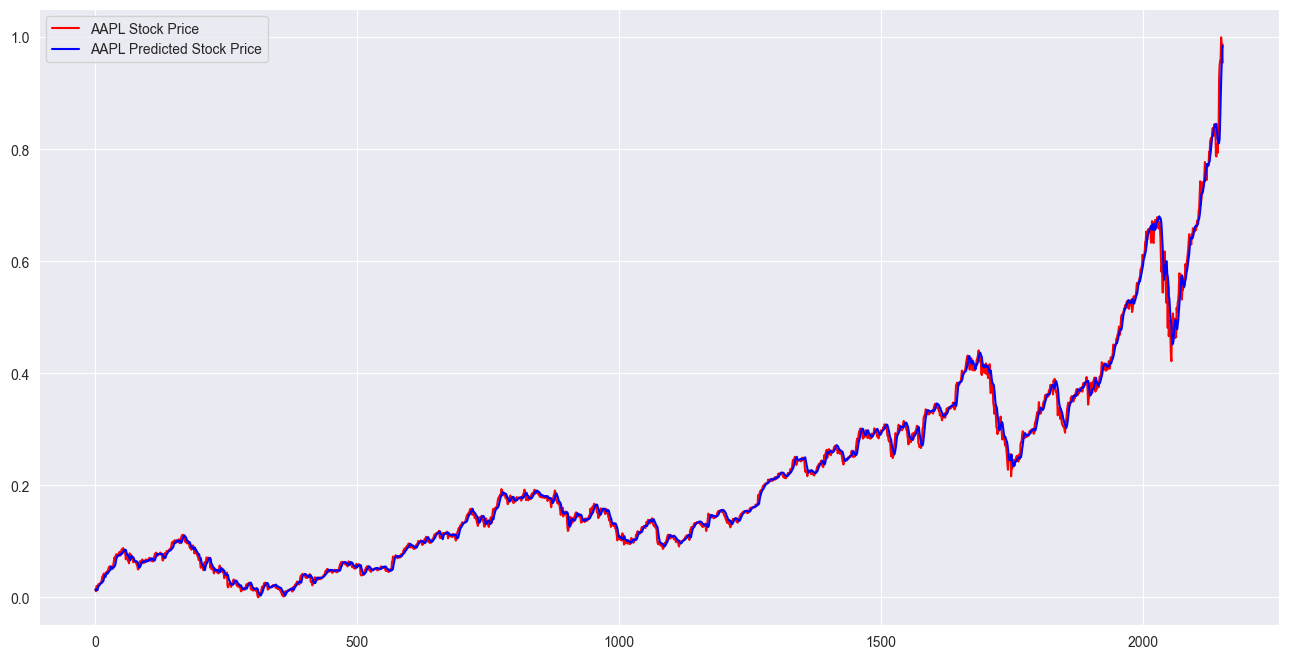

In [212]:
plt.figure(figsize=(16,8))
plt.plot(y, color = 'red', label = 'AAPL Stock Price')
plt.plot(y_pred, color = 'blue', label = 'AAPL Predicted Stock Price')
plt.legend()
plt.show()

In [206]:
# R2 of the model
model.evaluate(x_test, y_test)

14/14 [==============================] - 0s 3ms/step - loss: 5.2630e-04 - mse: 5.2630e-04


[0.000526302435901016, 0.000526302435901016]

___

### LSTM 2 with 50 lags

In [213]:
steps = 20
X2, y2 = input_ts(aapl_scaled, steps=steps, features=2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)
print(x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape)

(1710, 20, 2) (1710,) (428, 20, 2) (428,)


In [218]:
lstm_input2 = Input(shape=(steps, 2), name='lstm_input2')
inputs2 = LSTM(150, name='first_layer')(lstm_input2)
inputs2 = Dense(1, name='dense_layer')(inputs2)
output2 = Activation('linear', name='output')(inputs2)

model2 = Model(inputs=lstm_input2, outputs=output2)
adam2 = optimizers.Adam()
model2.compile(optimizer=adam2, loss='mse', metrics=['accuracy'])

model2.fit(x=x_train2, y=y_train2, batch_size=16, epochs=20, shuffle=True, validation_split = 0.1)

Epoch 1/20
97/97 [==============================] - 7s 25ms/step - loss: 8.1997e-04 - accuracy: 6.4977e-04 - val_loss: 6.7335e-04 - val_accuracy: 0.0000e+00
Epoch 2/20
97/97 [==============================] - 1s 14ms/step - loss: 8.9456e-05 - accuracy: 6.4977e-04 - val_loss: 3.6606e-04 - val_accuracy: 0.0000e+00
Epoch 3/20
97/97 [==============================] - 1s 14ms/step - loss: 8.6791e-05 - accuracy: 6.4977e-04 - val_loss: 3.9750e-04 - val_accuracy: 0.0000e+00
Epoch 4/20
97/97 [==============================] - 1s 14ms/step - loss: 8.7790e-05 - accuracy: 6.4977e-04 - val_loss: 4.6371e-04 - val_accuracy: 0.0000e+00
Epoch 5/20
97/97 [==============================] - 1s 14ms/step - loss: 8.1665e-05 - accuracy: 6.4977e-04 - val_loss: 3.0289e-04 - val_accuracy: 0.0000e+00
Epoch 6/20
97/97 [==============================] - 1s 13ms/step - loss: 7.9336e-05 - accuracy: 6.4977e-04 - val_loss: 2.7498e-04 - val_accuracy: 0.0000e+00
Epoch 7/20
97/97 [==============================] - 1s 14m

67/67 [==============================] - 2s 10ms/step


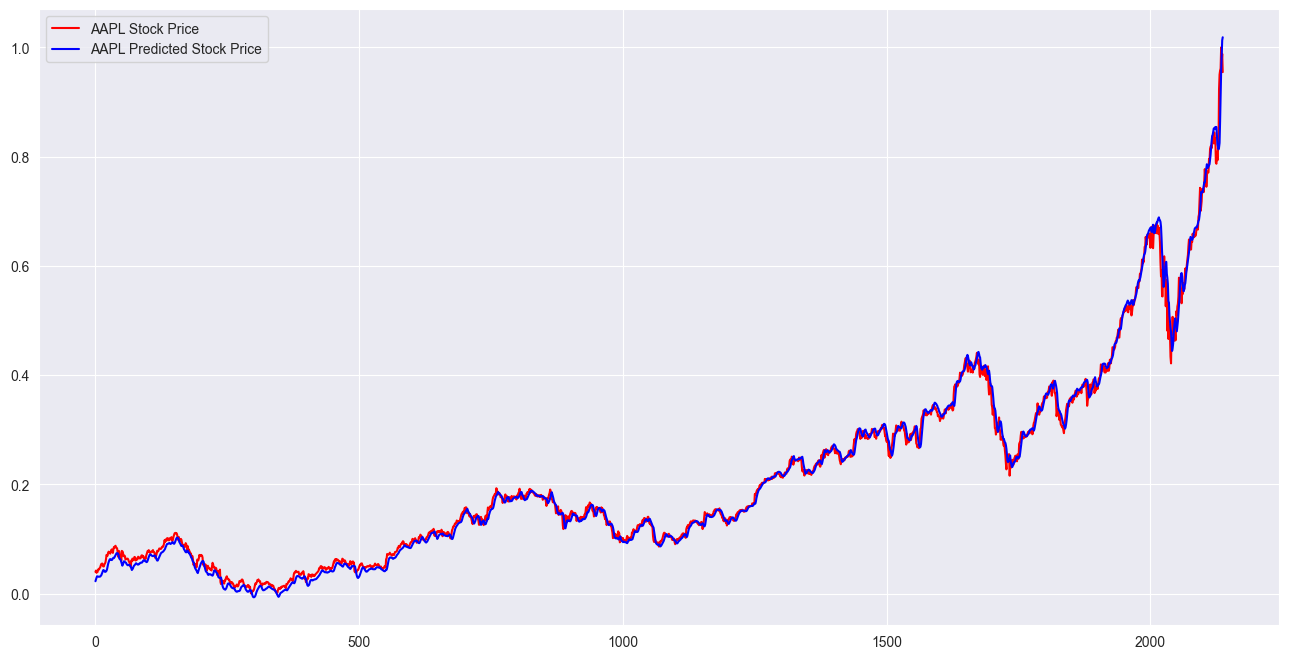

In [219]:
y_pred2 = model2.predict(X2)

plt.figure(figsize=(16,8))
plt.plot(y2, color = 'red', label = 'AAPL Stock Price')
plt.plot(y_pred2, color = 'blue', label = 'AAPL Predicted Stock Price')
plt.legend()
plt.show()

### Comments on LSTM 

We decided to use LSTMs (Long Short-Term Memory networks) because they offer advantages over other neural network architectures in the context of stock price prediction. These advantages are particularly noticeable due to the sequential and time-dependent nature of stock price data. LSTMs in fact are great in capturing and understanding long-range dependencies in time series data. They can also maintain and update information over extended time periods, allowing them to adapt to changing market conditions and trends. On the other hand, these attributes are not present in classic Feed Forward Neural Networks, which are typically dense and treat each sample unit as independent from the others.

About the differences between the two approach with low or high number of lags it really seems that using a higher number is actually improving the precision of the prediction, which is showed by the plot above. However it would be interesting to try this approach using as target the changes in prices instead of the actual prices to understand if the model has the real ability to generalize and not just the ability to use the data at time t-1 to predicts the prices.

- Comment 1: which method performs the best ? Is it in line with Gu et al., (2020). Can we really compare ?

*Comment*

In contrast to Gu et al. research paper, our findings showcase noticeable distinctions. The primary reason lies in the disparity of variables utilized for analysis. The referenced paper employed a comprehensive set of 94 variables in their study, whereas our own model simplifies the approach by focusing on just two key variables: prices and volumes. Consequently, employing a decision tree methodology in our specific scenario proves impractical. With only two variables at our disposal, attempting to utilize a decision tree would lack a meaningful basis for splitting the dataset. Even considering the incorporation of lags into our analysis, the outcome remains futile, as the essential prerequisite of ample distinguishing variables to warrant the use of a decision tree is lacking. Morover in the paper a more comparative approach ahas been tried, in our case with the only two variables available for our analysis we could only use an LSTM and leverage the lags to see prediction improvements


- Comment 2: What about Jiang et al. (2023) paper?

*Comment*

Compared to the approach outlined in the second paper, the methodology differs significantly. The authors of the second paper worked with a smaller dataset and chose to represent it graphically using a convolutional neural network (CNN). This particular type of neural network is adept at handling image data, which in their case, involved converting the financial data into images based on open and close values. However, in our scenario, we don't possess open and close data, and as such, utilizing a CNN (using only volume and closing prices) would have likely ended in poor perfomances compared to the model developed in the paper. For the type of financial data we had, which did not include open and close values—leveraging a neural network, particularly recurrent neural networks (RNNs) or long short-term memory (LSTM) networks, was more fitting as highlighted in the comments above.

### 1D CNN with 20 steps

In [250]:
steps = 20

aapl_scaled = aapl.copy()
aapl_scaled[['price', 'volume']] = scaler_x.fit_transform(aapl_scaled[['price', 'volume']])
aapl_scaled['target'] = scaler_y.fit_transform(aapl_scaled[['target']])
aapl_scaled = np.array(aapl_scaled)

X2, y2 = input_ts(aapl_scaled, steps=steps, features=2)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, shuffle=False)
print(x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape)

cnn_input = Input(shape=(steps, 2), name='cnn_input')
inputs = layers.Conv1D(150, kernel_size=2, activation='relu')(cnn_input)
inputs = layers.MaxPooling1D(pool_size=2)(inputs)
inputs = layers.Flatten()(inputs)
inputs = layers.Dense(1)(inputs)
output = layers.Activation('linear', name='output')(inputs)

model_cnn = Model(inputs=cnn_input, outputs=output, name='CNN')
adam = optimizers.Adam()
model_cnn.compile(optimizer=adam, loss='mse', metrics=['accuracy'])

model_cnn.summary()

(1710, 20, 2) (1710,) (428, 20, 2) (428,)
Model: "CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 cnn_input (InputLayer)      [(None, 20, 2)]           0         
                                                                 
 conv1d_7 (Conv1D)           (None, 19, 150)           750       
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 9, 150)           0         
 1D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 1350)              0         
                                                                 
 dense_9 (Dense)             (None, 1)                 1351      
                                                                 
 output (Activation)         (None, 1)                 0         
                     

Epoch 1/80


97/97 [==============================] - 2s 6ms/step - loss: 0.0014 - accuracy: 6.4977e-04 - val_loss: 9.2989e-04 - val_accuracy: 0.0000e+00
Epoch 2/80
97/97 [==============================] - 0s 3ms/step - loss: 1.7444e-04 - accuracy: 6.4977e-04 - val_loss: 6.6114e-04 - val_accuracy: 0.0000e+00
Epoch 3/80
97/97 [==============================] - 0s 3ms/step - loss: 1.5324e-04 - accuracy: 6.4977e-04 - val_loss: 6.5406e-04 - val_accuracy: 0.0000e+00
Epoch 4/80
97/97 [==============================] - 0s 3ms/step - loss: 1.3817e-04 - accuracy: 6.4977e-04 - val_loss: 6.2099e-04 - val_accuracy: 0.0000e+00
Epoch 5/80
97/97 [==============================] - 0s 4ms/step - loss: 1.2683e-04 - accuracy: 6.4977e-04 - val_loss: 5.6074e-04 - val_accuracy: 0.0000e+00
Epoch 6/80
97/97 [==============================] - 0s 3ms/step - loss: 1.1642e-04 - accuracy: 6.4977e-04 - val_loss: 5.2884e-04 - val_accuracy: 0.0000e+00
Epoch 7/80
97/97 [==============================] - 0s 3ms/step - loss: 1.0708e

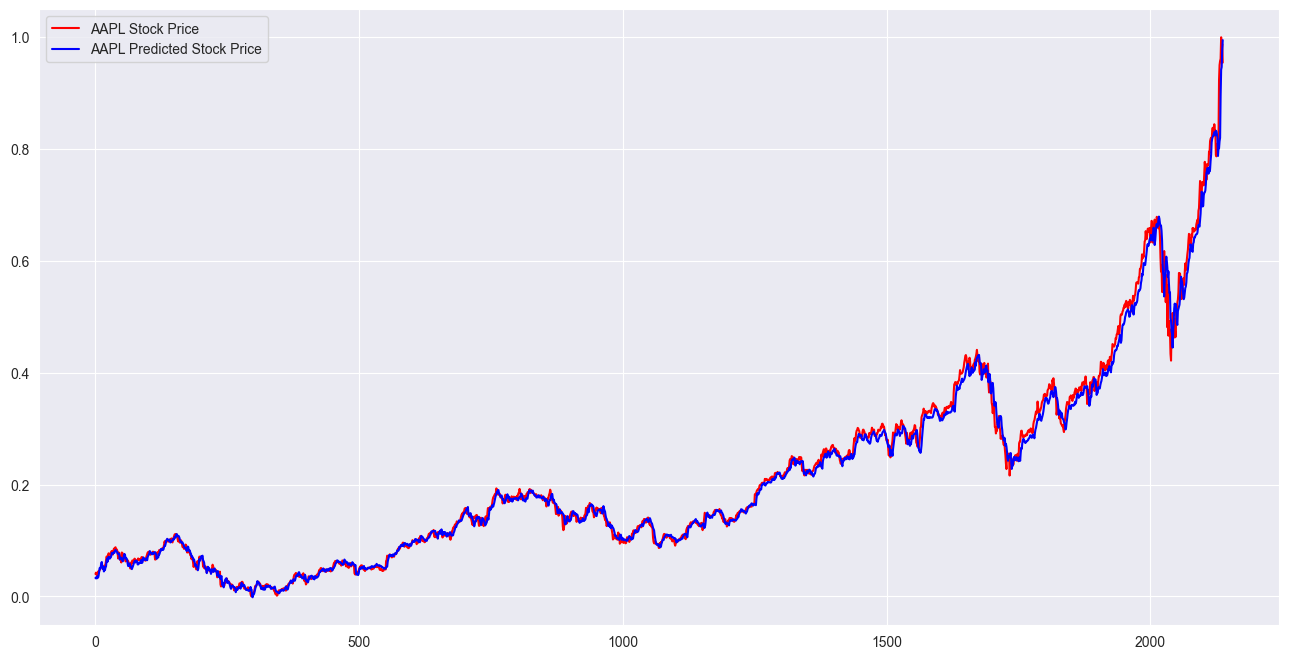

In [251]:
# Train the model

model_cnn.fit(x=x_train2, y=y_train2, batch_size=16, epochs=80, shuffle=True, validation_split = 0.1)

y_pred_cnn = model_cnn.predict(X2)

plt.figure(figsize=(16,8))
plt.plot(y2, color = 'red', label = 'AAPL Stock Price')
plt.plot(y_pred_cnn, color = 'blue', label = 'AAPL Predicted Stock Price')
plt.legend()
plt.show()

In [252]:
model_cnn.evaluate(x_test2, y_test2)

14/14 [==============================] - 0s 3ms/step - loss: 8.4704e-04 - accuracy: 0.0023


[0.0008470448083244264, 0.002336448524147272]

# Optional Task #4
## *Performance of the AI-driven portfolio*

1. Create a long portfolio by selecting every day the 4 assets with the highest predicted return at t+1 (i.e., you re-balance every day). You initially invest 100$, how much do you have at the end of the testing period ?

In [103]:
pchange.head()

Date      AAPL        BA         T       MGM      AMZN       IBM  \
0  2012-01-12       NaN       NaN       NaN       NaN       NaN       NaN   
1  2012-01-13 -0.003757 -0.012125 -0.001661  0.017974  0.014054 -0.007728   
2  2012-01-17  0.011581  0.008542  0.005968 -0.008130  0.017997  0.004678   
3  2012-01-18  0.010330 -0.002395  0.002641  0.038435  0.041936  0.005927   
4  2012-01-19 -0.003174  0.006639  0.002963  0.005484  0.026103 -0.003042   

       TSLA      GOOG     sp500  
0       NaN       NaN       NaN  
1 -0.214772 -0.007413 -0.004960  
2  0.154589  0.005728  0.003547  
3  0.007864  0.006865  0.011047  
4 -0.001867  0.010468  0.004927

The function `find_best_stocks()` returns the best stocks for a given day. It takes as arguments the day, the (predicted) returns and the number of stocks to select.

In [45]:
def find_best_stocks(t, y_pred, n=4, preds=True):
    '''
    t: time
    y_pred: predicted prices
    stocks: list of stocks
    n: number of stocks to buy
    preds: if True, y_pred is a dataframe of predictions for each stock, if False, y_pred is a row of a dataframe of predictions for each stocks
    '''

    if preds:
        y_pred = y_pred.iloc[t]
    else:
        y_pred = y_pred.iloc[0]
    sorted_stocks = list(y_pred.sort_values(ascending=False).index)[:n]
    return sorted_stocks

In [46]:
def buy_and_sell(balance, best_stocks, fee=0):
    '''
    The function buys the best stocks and sells the others
    ----------------
    balance: initial balance
    best_stocks: list of best stocks to buy
    fee: fee to pay for each transaction
    '''

    weights = [1/len(best_stocks) if stock in best_stocks else 0 for stock in stocks]
    portfolio = {stocks[i]: 0 for i in range(len(stocks))}
    for stock in best_stocks:
        portfolio[stock] = weights[stocks.get_loc(stock)] * balance * (1 - fee)

    balance = np.sum([portfolio[stock] for stock in best_stocks])

    return balance, portfolio

In [89]:
def ai_portfolio(balance=100, df=pchange, step=1, fee=0):
    '''
    The function tries to predict the 4 most profitable stocks at each step and rebalances the portfolio.
    The function returns the history of the balance, portfolio, returns and my returns
    --------------------------------
    balance: initial balance
    df: dataframe of prices
    step: steps of the trading strategy
    fee: fee for each transaction
    '''

    df = pchange.drop(['Date', 'sp500'], axis=1)[step:] * step   # 2-week returns

    my_returns_history = []
    returns_history = []
    balance_history = [balance]
    portfolio_history = []

    for t in tqdm(range(1, len(df)-step, step)):   # Change the step

        regressor = LinearRegression()
        regressor.fit(df.iloc[:t:step], df.iloc[1:t+step:step])

        y_pred = regressor.predict(df.iloc[:t:step])
        y_pred = pd.DataFrame(y_pred, columns=stocks)

        best_stocks = find_best_stocks(t+step, df)
        my_best_stocks = find_best_stocks(t+step, y_pred, preds=False)

        returns = round(df.iloc[t+step][best_stocks].mean(), 5)
        my_returns = round(df.iloc[t+step][my_best_stocks].mean(), 5)

        balance *= (1 + my_returns)

        returns_history.append(returns)
        my_returns_history.append(my_returns)

        balance, portfolio = buy_and_sell(balance, my_best_stocks, fee=fee)
        balance_history.append(balance)
        portfolio_history.append(portfolio)

    return balance_history, portfolio_history, returns_history, my_returns_history

In [101]:
balance_history, portfolio_history, returns_history, my_returns_history = ai_portfolio()

100%|██████████| 2156/2156 [00:16<00:00, 132.54it/s]


In [ ]:
# Count how many times each stock is present in the portfolio

portfolio_df = pd.DataFrame(portfolio_history)
portfolio_df = portfolio_df.replace(0, np.nan)
portfolio_df = portfolio_df.count(axis=0)
# portfolio_df = portfolio_df.sort_values(ascending=False)

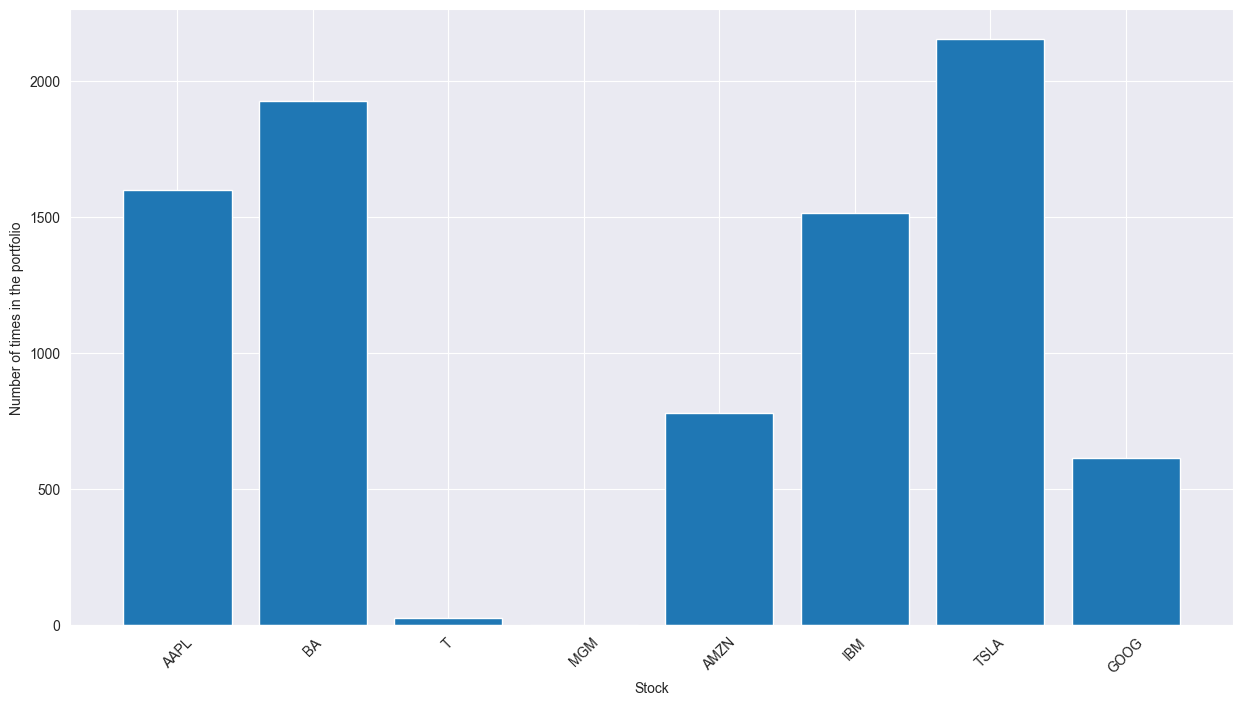

In [ ]:
# Plot the distribution of the stocks in the portfolio

fig = plt.figure(figsize=(15, 8))
plt.bar(portfolio_df.index, portfolio_df.values)
plt.xticks(rotation=45)
plt.xlabel('Stock')
plt.ylabel('Number of times in the portfolio')
plt.show()

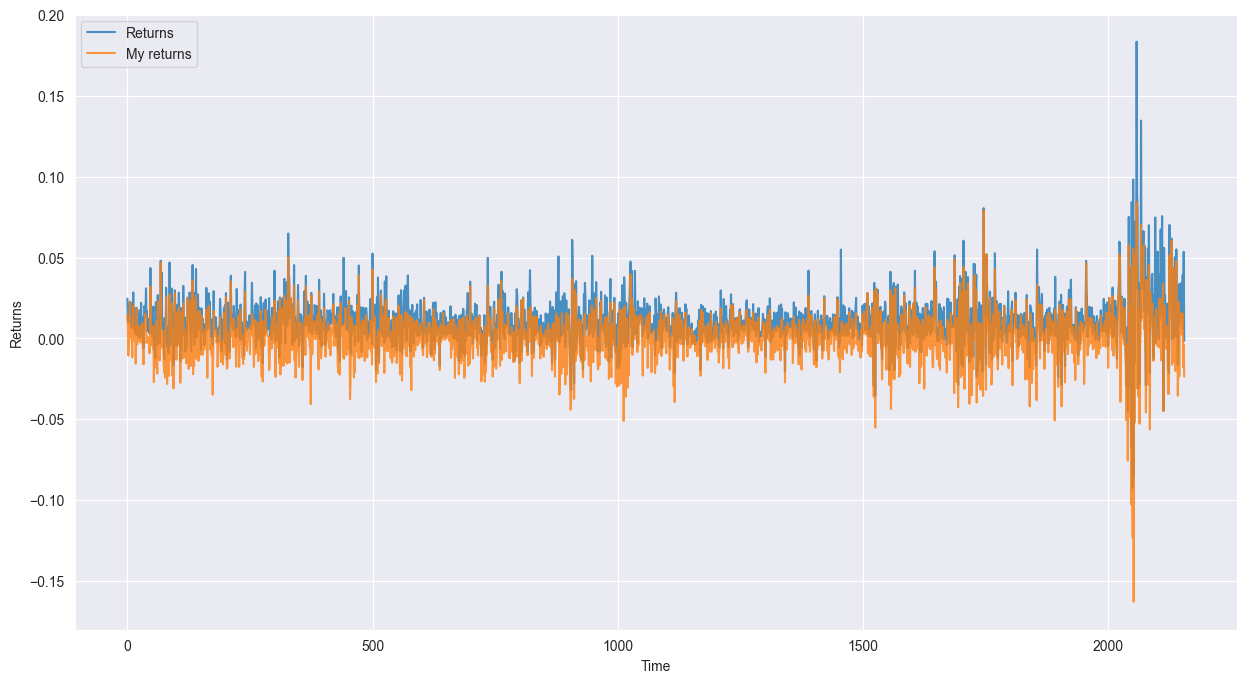

In [ ]:
# Plot the optimal returns and the returns of the AI portfolio

fig = plt.figure(figsize=(15, 8))
plt.plot(returns_history, label='Returns', alpha=0.8)
plt.plot(my_returns_history, label='My returns', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [102]:
correct_predictions = np.sum([1 for i in range(len(returns_history)) if returns_history[i] == my_returns_history[i]])
check_count = np.sum([1 for i in range(len(returns_history)) if returns_history[i] < my_returns_history[i]])

print(f'The AI predicted the correct stocks {correct_predictions} times out of {len(returns_history)} - {correct_predictions/len(returns_history)*100:.2f}%')
print(f'AI portfolio is better than the best portfolio {check_count} times out of {len(returns_history)} - {check_count/len(returns_history)*100:.2f}%')

The AI predicted the correct stocks 36 times out of 2156 - 1.67%
AI portfolio is better than the best portfolio 0.0 times out of 2156 - 0.00%


As expected, the model cannot beat the actual market. In fact there is no occurency of "AI-generated" returns which are strictly higher than the returns computed with the actual best stocks obtained from looking at the actual returns in the next period.

Of course this has no financial validity, it is just a check.

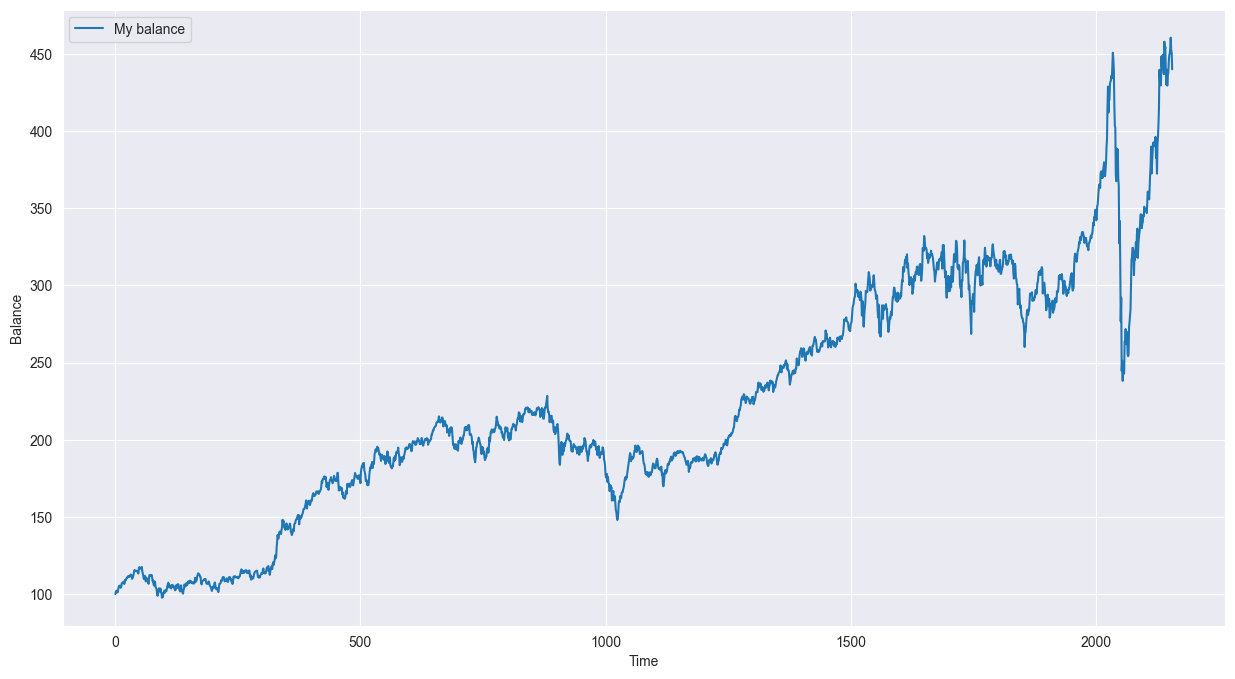

In [ ]:
# Plot the balance history

fig = plt.figure(figsize=(15, 8))
plt.plot(balance_history, label='My balance')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()

2. Compare your result to 1000 portfolios with random weights (you generate the weights at the beginning of the testing period and you never re-balance your portfolio).

In [ ]:
def random_portfolios(df=pchange, n=1000):
    '''
    The function generates n random portfolios and returns the list of returns
    --------------------------------
    df = dataframe with price changes
    n = number of random portfolios to generate
    '''

    df = pchange.drop(['Date', 'sp500'], axis=1)[1:]

    # Create a list of random weights
    random_weights = []

    for i in range(n):
        weights = np.random.dirichlet(np.ones(len(stocks)), size=1)[0] # Generate random weights
        # weights = np.random.random(len(stocks))
        # weights /= np.sum(weights)
        random_weights.append(weights)

    # Create a list of random returns
    random_returns = []

    for weights in tqdm(random_weights):

        my_returns = np.sum([df[stock].mean() * weights[stocks.get_loc(stock)] for stock in stocks])
        random_returns.append(my_returns)

    return random_returns

In [ ]:
random_portfolios_returns = random_portfolios(pchange)

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2221.60it/s]


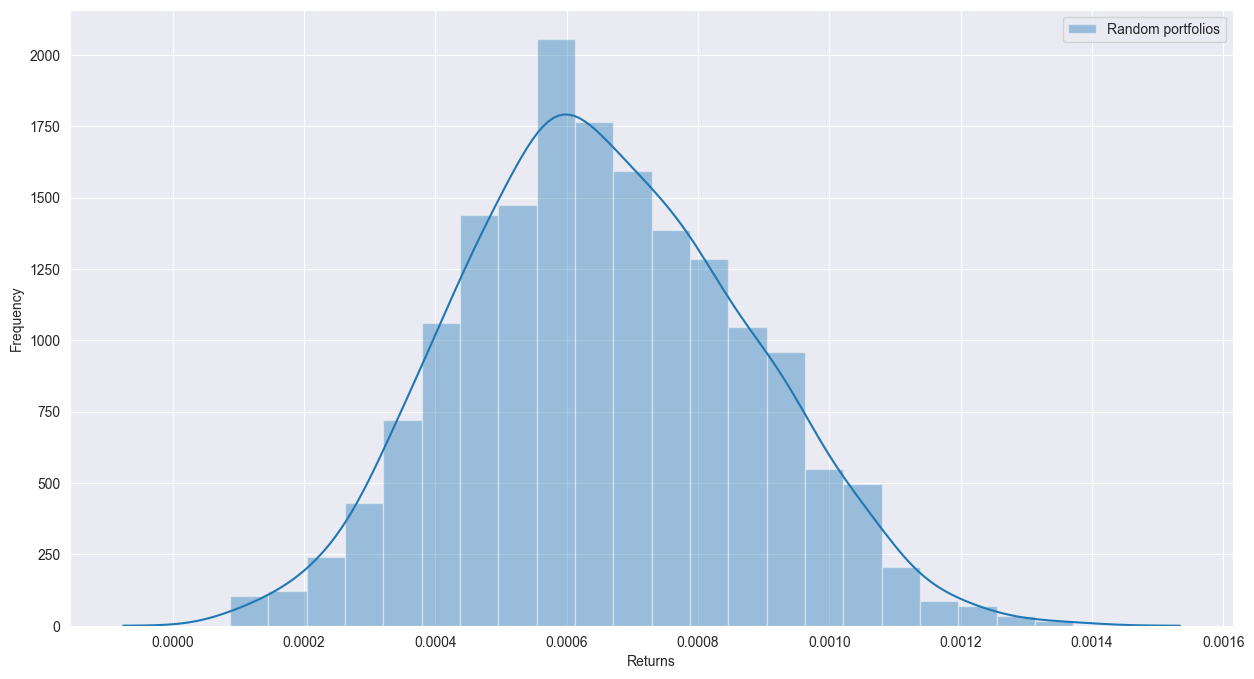

In [ ]:
# Plot the random returns and the returns of the AI portfolio
fig = plt.figure(figsize=(15, 8))
sns.distplot(random_portfolios_returns, label='Random portfolios', kde=True)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

As we can see from the plot, the random portfolios are not able to beat the AI.

Surprisingly, the distribution of the random returns is almost always positive. In fact if we look at the mean of each stock returns, we can see that they are all positive but one. The negative return of one of the stocks is compensated by the positive returns of the others.

In [ ]:
pchange.drop(['Date', 'sp500'], axis=1).mean()

AAPL    0.000919
BA      0.000403
T       0.000001
MGM     0.000265
AMZN    0.001327
IBM    -0.000164
TSLA    0.001800
GOOG    0.000719
dtype: float64

3. Imagine that you now pay trading fees : 3% of the amount invested is charged for every transaction, what is the new performance of your AI-driven portfolio ?
    - You want to sell 50$ of stock A to buy the same amount of stock B, you will be charged 1.5$, so you’ll end up with only 48.5$ invested in stock B.

In [ ]:
balance_history, portfolio_history, returns_history, my_returns_history = ai_portfolio(fee=0.03)

  0%|          | 0/2156 [00:00<?, ?it/s]

100%|██████████| 2156/2156 [00:12<00:00, 173.96it/s]


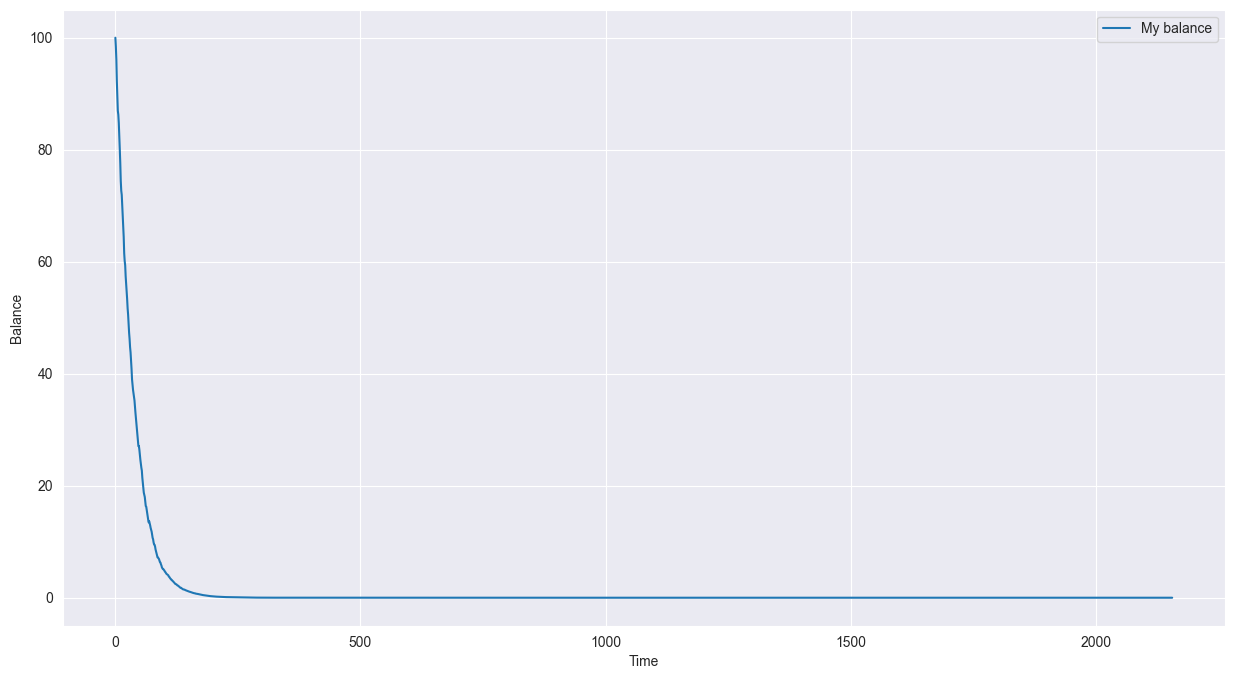

In [ ]:
# Plot the balance history

fig = plt.figure(figsize=(15, 8))
plt.plot(balance_history, label='My balance')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()

Daily trading is too expensive for this strategy. We can try to re-balance the portfolio every week or every month.

In [85]:
balance_history_step, portfolio_history_step, returns_history_step, my_returns_history_step = ai_portfolio(step=14, fee=0)

100%|██████████| 153/153 [00:01<00:00, 138.65it/s]


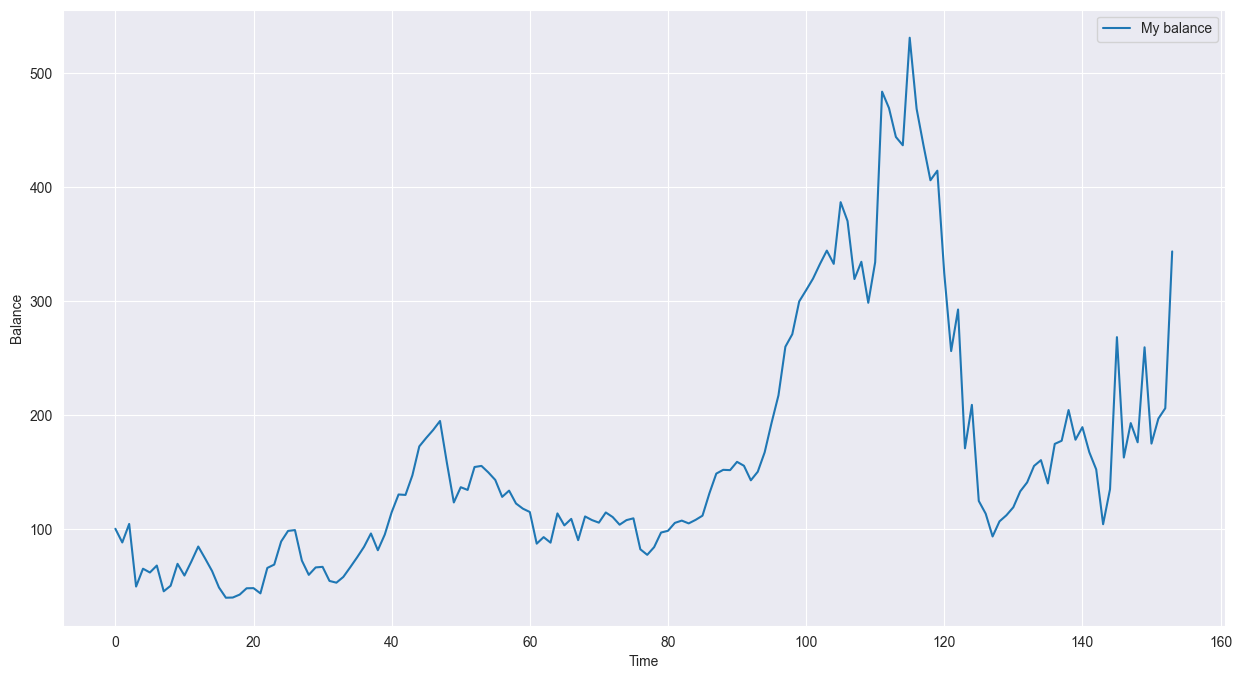

In [86]:
# Plot the balance history

fig = plt.figure(figsize=(15, 8))
plt.plot(balance_history_step, label='My balance')
plt.xlabel('Time')
plt.ylabel('Balance')
plt.legend()
plt.show()

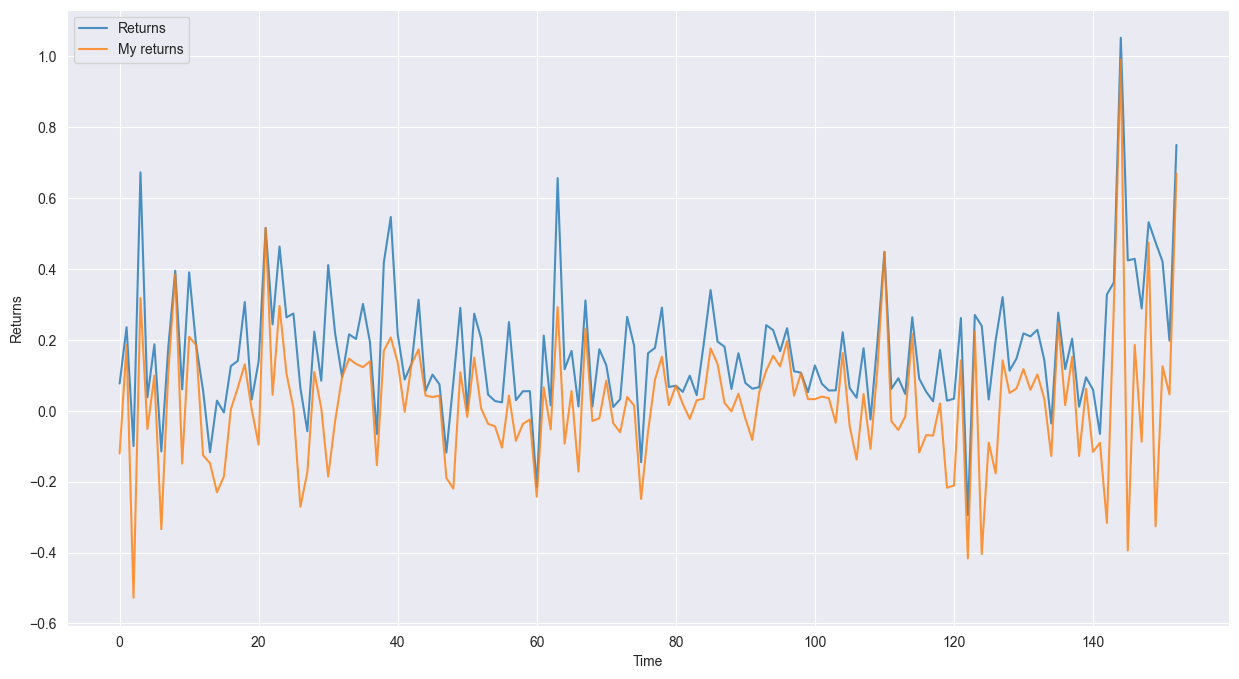

In [87]:
# Plot the optimal returns and the returns of the AI portfolio

fig = plt.figure(figsize=(15, 8))
plt.plot(returns_history_step, label='Returns', alpha=0.8)
plt.plot(my_returns_history_step, label='My returns', alpha=0.8)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.legend()
plt.show()

In [88]:
correct_predictions = np.sum([1 for i in range(len(returns_history_step)) if returns_history_step[i] == my_returns_history_step[i]])
check_count = np.sum([1 for i in range(len(returns_history_step)) if returns_history_step[i] < my_returns_history_step[i]])

print(f'The AI predicted the correct stocks {correct_predictions} times out of {len(returns_history_step)} - {correct_predictions/len(returns_history_step)*100:.2f}%')
print(f'AI portfolio is better than the best portfolio {check_count} times out of {len(returns_history_step)} - {check_count/len(returns_history_step)*100:.2f}%')

The AI predicted the correct stocks 5 times out of 153 - 3.27%
AI portfolio is better than the best portfolio 0.0 times out of 153 - 0.00%
